In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=
import sys
sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=


In [17]:
%autoreload
from tqdm import tqdm_notebook
from matplotlib.lines import Line2D

import collections, datetime, itertools, math, os, time, traceback, matplotlib.pyplot as plt
%matplotlib inline

from latent_patient_trajectories.constants import *
from latent_patient_trajectories.utils import *

In [3]:
DESIRED_ROTATIONS = {
    'MIMIC-III': {'0', '7', '8', '9', '1'},
    'eICU':      {'0', '1', '2', '3', '4'},
}

hyperaparameter_search_global_results_filepath = '../results/hyperparameter_search_results.pkl'
main_experiment_global_results_filepath = '../results/main_experiment_results.pkl'

## Reading Hyperparameter Search Results
We read all the raw hyperparameter search results in this notebook so we can
  1) Validate that the runs in the task_generalizability_experiments below match the optimal hyperparameters
  2) Use the hyperparameter search runs as full MT results
  3) Use the single-task hyperparameter search runs as full ST results.

In [4]:
assert os.path.isfile(hyperaparameter_search_global_results_filepath)

hyperparameter_search_results = depickle(hyperaparameter_search_global_results_filepath)
    
for k, rd in hyperparameter_search_results.items():
    keys = f": {', '.join(rd.keys())}" if len(rd) < 15 else ""
    print(f"Pre-loaded {len(rd)} experiments for {k}{keys}")

Pre-loaded 7 experiments for eICU: discharge, mortality, los, acuity, next_timepoint_info, MT, masked_imputation
Pre-loaded 12 experiments for MIMIC-III: icd10, discharge, mortality, los, readmission, future_treatment_sequence, acuity, next_timepoint_info, dnr, cmo, MT, masked_imputation


In [5]:
DERIVED_KEYS = {
    'do_masked_imputation': ['imputation_mask_rate'],
    'do_learning_rate_decay': ['learning_rate_decay', 'learning_rate_step'],
    'do_weight_decay': ['weight_decay'],
}

RELEVANT_KEYS = {
    'GRU': [
          "max_seq_len",
          "do_eicu",
          "epochs",

          "in_dim",
          "hidden_size",
          "batch_size",
          "learning_rate",
          "do_learning_rate_decay",
          "learning_rate_decay",
          "learning_rate_step",
          "hidden_dropout_prob",
        
          "dropout",
          "gru_num_hidden",
          "gru_hidden_layer_size",
          "gru_pooling_method",
        
          "do_masked_imputation",

          "imputation_mask_rate",
          
          "do_bidirectional",

          "do_weight_decay",
          "weight_decay",
          "ablate",
#           "gru_fc_layer_sizes", # THIS IS NOT USED UNTIL THE BUG IS FIXED SO IS OMITTED.
    ]
}

def print_args(a):
    assert a.modeltype == 'GRU', f"{a.modeltype} not yet supported!"
    
    keys = RELEVANT_KEYS[a.modeltype]
    for base, derived in DERIVED_KEYS.items():
        if not (base in keys and getattr(a, base)): keys = [k for k in keys if k not in derived]
        
    relevant_args = {k: v for k, v in vars(a).items() if k in keys}
    print(json.dumps(relevant_args, indent=2))

#### Validation of Weights

Here, we validate all the hyperparameter runs, in that the expected weights change during training given our expected ablations and task inclusion/exclusion criteria. Note that we do observe two instances (out of all our _many_ hyperparameter search results) where some weights we did expect to change didn't---this isn't particularly troubling. Moreso is if weights that we didn't expect to change did change, as this could indicate a failure to ablate properly. Overall, these help validate our runs.

In [6]:
sharp_validation_failures = {}

for dataset, d in hyperparameter_search_results.items():
    sharp_validation_failures[dataset] = {}
    for t, d in d.items():        
        if not d or not d['gru']: continue
        sharp_validation_failures[dataset][t] = {}
        
        config = d['gru']['config']            
        d = d['gru']['results']
        for rotation, d in d.items():
            if d['num_no_error'] <= 5: continue
            
            assert d['num_validated_valid'] + d['num_validated_invalid'] > 0, (
                f"Must validate something for runs [{dataset}][{t}][{'gru'}][{rotation}]"
            )
            
            if d['num_validated_invalid'] == 0: continue
                
            to_print = []
            for k, invalid_d in d['invalid_results'].items():
                if invalid_d['invalid_should_not_change_do (names)']:
                    to_print.append((k, invalid_d))
                    continue
                
                all_match = True
                for w in invalid_d['invalid_should_change_do_not']:
                    if not (type(w) is str and w.startswith('gru.weight_hh_l') and w.endswith('_reverse')):
                        all_match = False
                        break
                
                if not all_match: to_print.append((k, invalid_d))
                    
            if to_print:
                sharp_validation_failures[dataset][t][rotation] = to_print
                keys = list(set(k for k, d in to_print))
                invalid_should_change = set()
                invalid_should_no_change = set()
                for k, invalid_d in to_print:
                    invalid_should_change.update(invalid_d['invalid_should_change_do_not'])
                    invalid_should_no_change.update(invalid_d['invalid_should_not_change_do (names)'])
                    
                print(
                    f"{dataset}, {'All tasks' if t is None else t}, rotation {rotation} "
                    f"has {len(to_print)} / {d['num_no_error']} validation failures:\n"
                    f"{', '.join(keys[:3])}{', ...' if len(keys) > 3 else ''}"
                )
                if invalid_should_change:
                    invalid_should_change = [
                        x if type(x) is str else '/'.join(x) for x in invalid_should_change
                    ]
                    print(f"Should've changed: {', '.join(invalid_should_change)}")
                if invalid_should_no_change:
                    invalid_should_no_change = [
                        x if type(x) is str else '/'.join(x) for x in invalid_should_no_change
                    ]
                    print(f"Shouldn't have changed: {', '.join(invalid_should_no_change)}")
                print()
    print()

eICU, mortality, rotation 4 has 1 / 100 validation failures:
6d50211463b5bee88b26a7020bd55785
Should've changed: statics_projector[bias], ts_projector[bias], gru.bias_hh_l1_reverse, gru.bias_hh_l0


MIMIC-III, MT, rotation 1 has 1 / 100 validation failures:
7ea2efe058095555975330d1e798ad4c
Should've changed: task_heads.tasks_binary_multilabel.bias/icd_mental




In [7]:
no_err_counts, invalid_counts, best_keys = {}, {}, {}
datasets = ['MIMIC-III', 'eICU']
dataset_idxs = {k: i for i, k in enumerate(datasets)}

for dataset, d in hyperparameter_search_results.items():
    for t, d in d.items():        
        if not d or not d['gru']: continue
        sharp_validation_failures[dataset][t] = {}
            
        d = d['gru']['results']
        for rotation, d in d.items():
            key = (t, rotation)
            for dd, res in (
                (no_err_counts, d['num_no_error']), (invalid_counts, d['num_validated_invalid']),
                (best_keys, d['best_key'])
            ):
                if key not in dd: dd[key] = [np.NaN, np.NaN]
                dd[key][dataset_idxs[dataset]] = res

no_err_counts_df = pd.DataFrame(no_err_counts, index = datasets)
no_err_counts_df.columns.names = ('Task', 'Rotation')
invalid_counts_df = pd.DataFrame(invalid_counts, index = datasets)
invalid_counts_df.columns.names = ('Task', 'Rotation')
best_key_df = pd.DataFrame(best_keys, index = datasets)
best_key_df.columns.names = ('Task', 'Rotation')

no_err_counts_df.index = pd.MultiIndex.from_tuples((d, "No Error Cnt") for d in no_err_counts_df.index)
invalid_counts_df.index = pd.MultiIndex.from_tuples((d, "Invalid Cnt") for d in invalid_counts_df.index)
best_key_df.index = pd.MultiIndex.from_tuples((d, "Best Key") for d in best_key_df.index)

no_err_counts_df.sort_index(axis=1, inplace=True)
invalid_counts_df.sort_index(axis=1, inplace=True)
best_key_df.sort_index(axis=1, inplace=True)

joint_df = no_err_counts_df.T.join((invalid_counts_df.T, best_key_df.T), how='outer')
joint_df.columns.names = ('Dataset', 'Measure')
joint_df.sort_index(axis=1, inplace=True)

## Task Generalizability PT/FT Results

In [9]:
COLORS = {
    ABBREVIATIONS['Imminent Mortality']:              '#332288',
    ABBREVIATIONS['Comfort Measures']:                '#117733',
    ABBREVIATIONS['DNR Ordered']:                     '#44AA99',
    ABBREVIATIONS['ICD Code Prediction']:             '#88CCEE',
    ABBREVIATIONS['Long LOS']:                        '#DDCC77',
    ABBREVIATIONS['30-day Readmission']:              '#CC6677',
    ABBREVIATIONS['Imminent Discharge']:              '#AA4499',
    ABBREVIATIONS['Final Acuity Outcome']:            '#882255',
    ABBREVIATIONS['Next Hour Will-be-measured']:      '#1B5D41',
    ABBREVIATIONS['Future Treatment Sequence (FTS)']: '#B59FEB',
}

MODE_COLORS = {
    'ST': '#117733',
    'MT': '#88CCEE',
    'FTF': '#CC6677',
    'FTD': 'blue',
}
MODE_STYLES = {
    'ST':  ('dashdot', 'o'),
    'MT':  ('dotted',  '^'),
    'FTF': ('solid',   '*'),
    'FTD': ('dashed',  '+'),
}

TASK_ORDER = [
    ABBREVIATIONS['Imminent Mortality'],
    ABBREVIATIONS['Comfort Measures'],
    ABBREVIATIONS['DNR Ordered'],
    ABBREVIATIONS['Imminent Discharge'],
    ABBREVIATIONS['ICD Code Prediction'],
    ABBREVIATIONS['Long LOS'],
    ABBREVIATIONS['30-day Readmission'],
    ABBREVIATIONS['Final Acuity Outcome'],
    ABBREVIATIONS['Next Hour Will-be-measured'],
    ABBREVIATIONS['Future Treatment Sequence (FTS)'],
]
def sort_to_order(tasks):
    return [t for t in TASK_ORDER if t in tasks] + sorted([t for t in tasks if t not in TASK_ORDER])

In [10]:
assert os.path.isfile(main_experiment_global_results_filepath)

full = depickle(main_experiment_global_results_filepath)

In [11]:
for k, rd in full.items():
    keys = f": {', '.join(rd.keys())}" if len(rd) < 16 else ""
    print(f"Loaded {len(rd)} PT/FT experiments for {k}{keys}")

Loaded 12 PT/FT experiments for MIMIC-III: MT, cmo, next_timepoint_info, los, icd10, future_treatment_sequence, dnr, acuity, mortality, discharge, readmission, masked_imputation
Loaded 7 PT/FT experiments for eICU: MT, next_timepoint_info, los, acuity, mortality, discharge, masked_imputation


In [12]:
def nested_safe_access(d, *keys, used=[]):
    used = [f"'{k}'" if type(k) is str else str(k) for k in used]
    for k in keys:
        assert k in d, f"Missing {k}! Options: {d.keys()} (nested [{']['.join(used)}])"
        d = d[k]
        used.append(f"'{k}'" if type(k) is str else str(k))
    return d

# TODO(mmd): Use this throughout
def get_rng(rng, tqdm, desc=None, leave=False):
    try: N = len(rng)
    except:
        rng = list(rng)
        N = len(rng)
    
    return rng if N <= 1 or tqdm is None else tqdm(rng, total=N, desc=desc, leave=leave)

def reorg_results(full_results_dict, tqdm=None):
    out = {}
    
    metrics_list = list(itertools.product(('tuning', 'test'), ('AUROC', 'AUPRC')))
    data_fracs = [1] + list(SMALL_DATA_FRACS)
    
    for d, rd in get_rng(full_results_dict.items(), tqdm, desc="Datasets", leave=True):
        out[d] = {}
        
        for setting, rd in get_rng(rd.items(), tqdm, desc="Settings"):
            single_task = (setting not in ('MT', 'masked_imputation'))
            out[d][setting] = {}
        
            for m, rd in get_rng(rd.items(), tqdm, desc="Models"):
                if m not in out[d][setting]: out[d][setting][m] = {}
                rotations = rd['rotations']
                results = rd['results']

                for sp, metric in get_rng(metrics_list, tqdm, desc="Metrics/Splits"):
                    if (sp, metric) not in out[d][setting][m]: out[d][setting][m][(sp, metric)] = {}
                    
                    for data_frac in get_rng(data_fracs, tqdm, desc="Data %s"):
                        FTF_on_targets_all, FTD_on_targets_all = {}, {}
                        FTF_off_targets_all, FTD_off_targets_all = {}, {}
                        FTF_off_targets_by_rot, FTD_off_targets_by_rot = {}, {}

                        for i, (rotation, rd) in get_rng(
                            enumerate(zip(rotations, results)), tqdm, desc="Rotations"
                        ):
                            exp_keys = nested_safe_access(rd, 'exp_keys', used=[d, setting, m, 'results', i])
                            assert len(exp_keys) == 1, "Can't process multiple experiment keys yet!"

                            tasks = []
                            FTF_on_targets, FTF_off_targets = [], {}
                            FTD_on_targets, FTD_off_targets = [], {}

                            try:
                                all_tasks = list(rd['results'][0]['results'].keys())
                            except KeyError as e:
                                print(d, setting, m, sp, metric, data_frac)
                                print(rd.keys())
                                raise
                                
                            all_task_abbrs = [ABLATIONS_TO_REPORTING_MAP[t] for t in all_tasks]
                            for task, rd in get_rng(rd['results'][0]['results'].items(), tqdm, desc="Tasks"):
                                task_abbr = ABLATIONS_TO_REPORTING_MAP[task]
                                tasks.append(task_abbr)

                                try:
                                    FTF = nested_safe_access(
                                        rd, 'FT', data_frac, 'results', 'FTF', f"{sp} manuscript ({metric})",
                                        used=[d, setting, m, 'results', i, 'results', 0, 'results', task]
                                    )
                                except AssertionError as e:
                                    print(f"Missing FTF for {d}, {setting}, {m}, {rotation}:\n{e}")
                                    print("Setting to NaN and continuing.")
                                    FTF = pd.Series([np.NaN] * len(all_tasks), index=all_task_abbrs)

                                try:
                                    FTD = nested_safe_access(
                                        rd, 'FT', data_frac, 'results', 'FTD', f"{sp} manuscript ({metric})",
                                        used=[d, setting, m, 'results', i, 'results', 0, 'results', task]
                                    )
                                except AssertionError as e:
                                    if not single_task:
                                        print(f"Missing FTD for {d}, {setting}, {m}, {rotation}:\n{e}")
                                        print("Setting to NaN and continuing.")
                                    FTD = pd.Series([np.NaN] * len(all_tasks), index=all_task_abbrs)

                                other_tasks = [t for t in all_task_abbrs if t != task_abbr]

                                try:
                                    FTF_on_targets.append(FTF[task_abbr])
                                    if False and single_task:
                                        FTF_off_targets[task_abbr] = pd.Series(
                                            [np.NaN] * len(other_tasks), index=other_tasks
                                        )
                                    else: FTF_off_targets[task_abbr] = FTF[other_tasks]
                                    FTF_off_targets[task_abbr].index.name = "Measured Task"

                                    FTD_on_targets.append(FTD[task_abbr])
                                    FTD_off_targets[task_abbr] = FTD[other_tasks]
                                    FTD_off_targets[task_abbr].index.name = "Measured Task"
                                except:
                                    print(d, setting, m, sp, data_frac, rotation, i, task)
                                    print(FTF)
                                    print(FTD)
                                    display(FTF)
                                    display(FTD)
                                    print(task_abbr)
                                    print(other_tasks)
                                    
                                    raise

                            FTF_on_targets_all[rotation] = pd.Series(FTF_on_targets, index=tasks)
                            FTD_on_targets_all[rotation] = pd.Series(FTD_on_targets, index=tasks)

                            FTF_off_targets_by_rot[rotation] = pd.DataFrame(FTF_off_targets)
                            FTF_off_targets_by_rot[rotation].columns.name = "Target Task"
                            FTD_off_targets_by_rot[rotation] = pd.DataFrame(FTD_off_targets)
                            FTD_off_targets_by_rot[rotation].columns.name = "Target Task"

                            FTF_off_targets_all.update({
                                (rotation, k): v for k, v in FTF_off_targets.items()
                            })
                            FTD_off_targets_all.update({
                                (rotation, k): v for k, v in FTD_off_targets.items()
                            })

                        FTF_on_targets_all = pd.DataFrame(FTF_on_targets_all)
                        FTF_on_targets_all.index.names = ["Tasks"]
                        FTD_on_targets_all = pd.DataFrame(FTD_on_targets_all)
                        FTD_on_targets_all.index.names = ["Tasks"]

                        FTF_off_targets_all = pd.DataFrame(FTF_off_targets_all)
                        FTD_off_targets_all = pd.DataFrame(FTD_off_targets_all)

                        assert data_frac not in out[d][setting][m][(sp, metric)]
                        out[d][setting][m][(sp, metric)][data_frac] = {
                            'FTF_on_target': FTF_on_targets_all,
                            'FTF_off_target': FTF_off_targets_all,
                            'FTD_on_target': FTD_on_targets_all,
                            'FTD_off_target': FTD_off_targets_all,
                            'FTF_off_target_by_rot': FTF_off_targets_by_rot,
                            'FTD_off_target_by_rot': FTD_off_targets_by_rot,
                        }
                    
                    FTF_on_target_parts, FTD_on_target_parts = [], []
                    for data_frac, data_frac_results in out[d][setting][m][(sp, metric)].items():
                        FTF_pt = data_frac_results['FTF_on_target'].copy()
                        FTF_pt.columns = pd.MultiIndex.from_tuples(
                            ((data_frac, c) for c in FTF_pt.columns),
                            names = ("FT Dataset %", "Rotation")
                        )
                        FTD_pt = data_frac_results['FTD_on_target'].copy()
                        FTD_pt.columns = pd.MultiIndex.from_tuples(
                            ((data_frac, c) for c in FTD_pt.columns),
                            names = ("FT Dataset %", "Rotation")
                        )
                        FTF_on_target_parts.append(FTF_pt)
                        FTD_on_target_parts.append(FTD_pt)
                        
                    out[d][setting][m][(sp, metric)]['FTF_on_target'] = pd.concat(FTF_on_target_parts, axis=1)
                    out[d][setting][m][(sp, metric)]['FTD_on_target'] = pd.concat(FTD_on_target_parts, axis=1)

                    if single_task: continue
                        
                    PT_on_targets_all, PT_off_targets_all, PT_off_targets_by_rot = {}, {}, {}

                    for i, (rotation, rd) in enumerate(zip(rotations, results)):
                        assert len(rd['exp_keys']) == 1, "Can't process multiple experiment keys yet!"

                        tasks = []
                        PT_on_targets, PT_off_targets = [], {}

                        for task, rd in rd['results'][0]['results'].items():
                            task_abbr = ABLATIONS_TO_REPORTING_MAP[task]
                            tasks.append(task_abbr)

                            try:
                                PT = nested_safe_access(
                                    rd, 'PT', f"{sp} manuscript ({metric})", used=[d, setting, m, 'results', i, 'results', 0, 'results', task]
                                )
                            except KeyError as e:
                                print(d, setting, m, sp, rotation, task)
                                print(rd['PT'].keys())

                                raise

                            other_tasks = [t for t in FTF.index if t != task_abbr]

                            # should be 0.5
                            PT_on_targets.append(PT[task_abbr])
                            # should not be 0.5
                            PT_off_targets[task_abbr] = PT[other_tasks]
                            PT_off_targets[task_abbr].index.name = "Measured Task"

                        PT_on_targets_all[rotation] = pd.Series(PT_on_targets, index=tasks)
                        PT_off_targets_by_rot[rotation] = pd.DataFrame(PT_off_targets)
                        PT_off_targets_by_rot[rotation].columns.names = ["Target Task"]
                        PT_off_targets_all.update({
                            (rotation, k): v for k, v in PT_off_targets.items()
                        })

                    PT_on_targets_all = pd.DataFrame(PT_on_targets_all)
                    PT_on_targets_all.index.names = ["Rotations"]
                    PT_off_targets_all = pd.DataFrame(PT_off_targets_all)

                    out[d][setting][m][(sp, metric)].update({
                        'PT_on_target': PT_on_targets_all,
                        'PT_off_target': PT_off_targets_all,
                        'PT_off_target_by_rot': PT_off_targets_by_rot,
                    })
                    
        # ST Re-alignment
        ST_merged = {}
        single_tasks = []
        for t, rd in out[d].items():
            if t in ('MT', 'masked_imputation'): continue
            single_tasks.append(t)
            
            for m, rd in rd.items():
                if m not in ST_merged: ST_merged[m] = {}
                
                for spm, rd in rd.items():
                    if spm not in ST_merged[m]: ST_merged[m][spm] = {}
                        
                    cont = ST_merged[m][spm]
                    for k in (('FTF_on_target', 'FTD_on_target')):
                        if k not in rd: continue
                        if k not in cont: cont[k] = []
                        cont[k].append(rd[k])
                    
                    for data_frac in data_fracs:
                        if data_frac not in rd: continue
                        if data_frac not in cont: cont[data_frac] = {}
                        cont_df = cont[data_frac]
                        rd_df = rd[data_frac]
                        
                        for k in ('FTF_off_target_by_rot', 'FTD_off_target_by_rot'):
                            if k not in rd_df: continue
                            if k not in cont_df: cont_df[k] = {}
                            
                            for rot, v in rd_df[k].items():
                                if rot not in cont_df[k]: cont_df[k][rot] = []
                                cont_df[k][rot].append(v)
                        
                        for k, v in rd_df.items():
                            if k.endswith('by_rot'): continue
                            assert type(v) is not dict
                            
                            if k not in cont_df: cont_df[k] = []
                            cont_df[k].append(v)
        
        out[d]['ST'] = {'tasks': single_tasks, 'pre_merge': ST_merged}
        for m, rd in ST_merged.items():
            out[d]['ST'][m] = {}
            for spm, rd in rd.items():
                out[d]['ST'][m][spm] = {}
                
                cont = out[d]['ST'][m][spm]
                for k in (('FTF_on_target', 'FTD_on_target')):
                    if k not in rd: continue
                        
                    try:
                        cont[k] = pd.concat(rd[k], axis=0, sort=True)
                    except Exception as e:
                        print(m, spm, k)
                        display(rd[k])
                        print(e)

                for data_frac in data_fracs:
                    if data_frac not in rd: continue
                    cont[data_frac] = {}
                    
                    cont_df = cont[data_frac]
                    rd_df = rd[data_frac]

                    for k in ('FTF_off_target_by_rot', 'FTD_off_target_by_rot'):
                        if k not in rd_df: continue
                        cont_df[k] = {}

                        for rot, v in rd_df[k].items():
                            try:
                                cont_df[k][rot] = pd.concat(v, axis=1, sort=True)
                            except Exception as e:
                                print(m, spm, data_frac, k, rot)
                                display(v)
                                print(e)

                    for k, v in rd_df.items():
                        if k.endswith('by_rot'): continue
                        assert type(v) is not dict
                        
                        try:
                            axis = 0 if k.endswith('on_target') else 1
                            cont_df[k] = pd.concat(v, axis=axis, sort=True)
                        except Exception as e:
                            print(m, spm, data_frac, k)
                            print(axis)
                            display(v)
                            print(e)
            
    return out

In [13]:
reorged_full = reorg_results(full, tqdm=tqdm_notebook)

In [14]:
idx = pd.IndexSlice
def make_manuscript_table(
    reorged_full, dataset, sp='test', metric='AUROC', mean_round=2, std_round=2, few_shot_percs=[0.01]
):
    MT_rd = reorged_full[dataset]['MT']['gru'][(sp, metric)]
    ST_rd = reorged_full[dataset]['ST']['gru'][(sp, metric)]
    
    
    group_levels = ['FT Dataset %']
    MT_FTF_agg = MT_rd['FTF_on_target'].T.groupby(level=group_levels, axis=0).agg(['mean', 'std', 'count']).T
    MT_FTD_agg = MT_rd['FTD_on_target'].T.groupby(level=group_levels, axis=0).agg(['mean', 'std', 'count']).T
    ST_agg = ST_rd['FTF_on_target'].T.groupby(level=group_levels, axis=0).agg(['mean', 'std', 'count']).T
        
    if 'masked_imputation' in reorged_full[dataset]:
        MI_rd = reorged_full[dataset]['masked_imputation']['gru'][(sp, metric)]
        MI_FTF_agg = MI_rd['FTF_on_target'].T.groupby(level=group_levels, axis=0).agg(['mean', 'std', 'count']).T
        MI_FTD_agg = MI_rd['FTD_on_target'].T.groupby(level=group_levels, axis=0).agg(['mean', 'std', 'count']).T
        
        all_dfs = [
            ('MT FTF', MT_FTF_agg), ('MT FTD', MT_FTD_agg), 
            ('MI FTF', MI_FTF_agg), ('MI FTD', MI_FTD_agg),         
            ('ST', ST_agg),
        ]
    else:
        all_dfs = [
            ('MT FTF', MT_FTF_agg), ('MT FTD', MT_FTD_agg), 
            ('ST', ST_agg),
        ]

    
    dfs_to_join, cnts_to_join, raw_means_to_join = [], [], []
    col_remapping = {1: 'Full Data'}
    for perc in few_shot_percs: col_remapping[perc] = f"Few-shot ({perc*100:.0f}%)"
        
    for label, df in all_dfs:
        df = df[[1] + few_shot_percs].rename(columns=col_remapping)
        df.columns.name = 'Dataset Size'
        
        raw_means = df.loc[idx[:, 'mean'], :]
        raw_means.index = raw_means.index.droplevel(1)
        raw_means.columns = pd.MultiIndex.from_tuples([(c, label) for c in raw_means.columns])
        raw_means.columns.names = ('Dataset Size', 'PT/FT Regime')
        
        
        mean = df.loc[idx[:, 'mean'], :].round(mean_round).astype(str)
        std = df.loc[idx[:, 'std'], :].round(std_round).astype(str)
        cnt = df.loc[idx[:, 'count'], :]
        
        mean.index = mean.index.droplevel(1)
        std.index = std.index.droplevel(1)
        
        mean.index.name = 'Task'
        std.index.name = 'Task'
        
        joint = mean.applymap(lambda x: f'${x}') + std.applymap(lambda x: f' \pm {x}$')
        joint.columns = pd.MultiIndex.from_tuples([(c, label) for c in joint.columns])
        joint.columns.names = ('Dataset Size', 'PT/FT Regime')
        
        cnt.columns = pd.MultiIndex.from_tuples([(c, label) for c in cnt.columns])
        cnt.columns.names = ('Dataset Size', 'PT/FT Regime')
        
        raw_means_to_join.append(raw_means)
        dfs_to_join.append(joint)
        cnts_to_join.append(cnt)
        
    final_raw_mean = raw_means_to_join[0].join(raw_means_to_join[1:]).sort_index(axis=1)
    final_aggs = dfs_to_join[0].join(dfs_to_join[1:]).sort_index(axis=1)
    final_cnts = cnts_to_join[0].join(cnts_to_join[1:]).sort_index(axis=1)
    
    max_coords = {}
    for eval_regime in set(raw_means.columns.get_level_values('Dataset Size')):
        for task, row in final_raw_mean[eval_regime].iterrows():
            if eval_regime not in max_coords: max_coords[eval_regime] = []
            
            max_coords[eval_regime].append((task, row.fillna(0).idxmax()))
    
    for eval_regime, opt_coords_list in max_coords.items():
        for task, coord in opt_coords_list:
            try:
                final_aggs.loc[task, (eval_regime, coord)] = (
                    '$\\boldsymbol{' + final_aggs.loc[task, (eval_regime, coord)][1:-1] + '}$'
                )
            except:
                display(eval_regime, task, coord)
                display(final_aggs)
                raise
                 
    return all_dfs, final_aggs, final_cnts
 
LINESTYLES = {'ST': ':', 'FTF': '-', 'FTD': '--', 'baseline': '-.'}
LINECOLORS = {
    'ST': 'brown',
    'MT FTF': 'orange', 'MT FTD': 'blue',
    'MI FTF': 'purple', 'MI FTD': 'red', # TODO: make colorblind friendly
    'baseline': 'black'
}
TASK_ORDER = ['MOR', 'CMO', 'DNR', 'ICD', 'LOS', 'REA', 'DIS', 'ACU', 'WBM', 'FTS']
def plot(all_dfs, dataset, metric):
    if type(all_dfs) in (list, tuple): 
        try:
            all_dfs = {k: v for k, v in all_dfs}
        except Exception as e:
            print(all_dfs)
            print(type(all_dfs))
            for i in all_dfs: 
                print(type(i))
                if type(i) in (list, tuple): print(len(i))
            raise
        
    assert type(all_dfs) is dict, "Wrong all_dfs type!"
    
    agg_dfs = {k: {} for k in all_dfs}
    for k, df in all_dfs.items():
        for agg in ('mean', 'std'):
            agg_df = df.loc[idx[:, agg], :]
            agg_df.index = agg_df.index.droplevel(1)
            agg_dfs[k][agg] = agg_df
    
    dataset_fractions = list(agg_dfs['MT FTF']['mean'].columns)
    
    observed_tasks = set()
    for k in agg_dfs: observed_tasks.update(agg_dfs[k]['mean'].index)
        
    tasks = [t for t in TASK_ORDER if t in observed_tasks]
    N_tasks = len(tasks)
    
    W = int(math.ceil(math.sqrt(N_tasks)))
    H = int(math.ceil(N_tasks / W))

    figs = {}
    for do_rel in (False, True):
        fig, axes_rows = plt.subplots(
            nrows=H, ncols=W, figsize=(W * 7, H * 7), sharex=True, sharey=True
        )
        fig.suptitle(f"{dataset} {'Relative' if do_rel else 'Absolute'} Performance", fontsize=32)
        figs[do_rel] = fig

        flat_axes_iter = list(itertools.chain.from_iterable(axes_rows))

        X = dataset_fractions
        ts = [t for t in tasks if t in agg_dfs['ST']['mean'].index] if do_rel else tasks
                     
        for i, (task, ax) in enumerate(zip(ts, flat_axes_iter)):
            ax.set_title(task, fontsize=18)
            ax.set_xscale('log')
            if (i // W) == H: ax.set_xlabel('FT Dataset Size (Fraction)', fontsize=24)
            if (i % W) == 0: ax.set_ylabel('AUROC', fontsize=24)

            if do_rel: base_val, base_style_key = 0, 'ST'
            else: base_val, base_style_key = 0.5 if metric == 'AUROC' else 0, 'baseline'
                     
            ax.axhline(
                y=base_val, linestyle=LINESTYLES[base_style_key], linewidth=1,
                color=LINECOLORS[base_style_key], label=base_style_key
            )
            
                     
            if do_rel:
                ST_means, ST_stds = agg_dfs['ST']['mean'], agg_dfs['ST']['std']

            for k, aggs in agg_dfs.items():
                if do_rel and k == 'ST': continue
                     
                means, stds = aggs['mean'], aggs['std']

                if task not in means.index: continue
                if do_rel and task not in ST_means.index: continue

                Y     = means.loc[task, X]
                if do_rel: Y -= ST_means.loc[task, X]
                     
                if do_rel: Y_err = np.sqrt(stds.loc[task, X]**2 + ST_stds.loc[task, X]**2)
                else: Y_err = stds.loc[task, X]

                linestyle = LINESTYLES[k if k in LINESTYLES else k.split()[1]]
                color     = LINECOLORS[k if k in LINECOLORS else k.split()[1]]

                ax.plot(X, Y, linestyle=linestyle, color=color, linewidth=2, label=k)
                ax.fill_between(X, Y-Y_err, Y+Y_err, color=color, alpha=0.15)

            if i == (N_tasks - 1): ax.legend(fontsize=24, bbox_to_anchor=(1.05, 0), loc='lower left')

        for ax in flat_axes_iter[i+1:]: ax.set_axis_off()
            
    return figs

def latex_print(df):
    df2 = df.copy()
    df2.index.names = ['']
    df2.columns = pd.MultiIndex.from_tuples((c1.replace('%', r'\%'), c2) for c1, c2 in df2.columns)
    print(df2.to_latex(escape=False))

def process_dataset(
    reorged_full, dataset, sp='test', metric='AUROC', mean_round=2, std_round=2, few_shot_percs=[0.01, 0.1]
):
    print(f"Processing {dataset}")
    
    all_dfs, final_aggs, final_cnts = make_manuscript_table(
        reorged_full, dataset, sp, metric, mean_round, std_round, few_shot_percs
    )
    
    off_target_dfs = {}
    PT_on_target_dfs = []
    for key in ('MT', 'masked_imputation'):
        if key not in reorged_full[dataset]: continue
        rd = reorged_full[dataset][key]['gru'][(sp, metric)]
        FTD_off_target = rd[1]['FTD_off_target'] 
        PT_off_target  = rd['PT_off_target']
        
        all_match = ((FTD_off_target == PT_off_target) | (PT_off_target.isnull())).all().all()
        if not all_match:
            print(f"ERROR: {dataset} FTD off target and PT off target don't match for {key}!")
        else: 
            print(f"{dataset} FTD off target and PT off target do match for {key}.")
        
        off_target_dfs[key] = {'PT': PT_off_target, 'FTD': FTD_off_target, 'all_match': all_match}
        
        PT_on_target = rd['PT_on_target'].agg(['mean', 'count', 'std'], axis=1)
        PT_on_target.columns = pd.MultiIndex.from_tuples((dataset, key, c) for c in PT_on_target.columns)
        PT_on_target_dfs.append(PT_on_target)
        
    PT_on_target = pd.concat(PT_on_target_dfs, axis=1)

    print(f"{dataset} PT on-target (ablated) task performance statistics:")
    display(PT_on_target)
    
    print(f"{dataset} Final Manuscript Table and Counts:")
    display(final_aggs)
    display(final_cnts)
    print("\n\n(for copying to latex):")
    latex_print(final_aggs)
    print("\n\n")
    
    figs = plot(all_dfs, dataset, metric)
        
    return all_dfs, final_aggs, final_cnts, PT_on_target, off_target_dfs, figs

In [15]:
def reshape(df, add_dataset=None):
    cols = df.columns.get_level_values('Dataset Size')
    eval_regimes = list(set(cols))
    eval_positions = {k: min(i for i, v in enumerate(cols) if v == k) for k in eval_regimes}
    eval_positions = {'Few-shot (1%)': 1, 'Few-shot (10%)': 10, 'Full Data': 100,}
    
    eval_regimes = sorted(eval_regimes, key=lambda x: eval_positions[x])
    
    dfs = []
    for e in eval_regimes:
        sub = df[e].copy()
        tasks = [t for t in TASK_ORDER if t in sub.index.get_level_values('Task')]
        sub = sub.loc[tasks]
        
        sub['Dataset Size'] = e
        sub.reset_index(inplace=True)
        sub.set_index(['Dataset Size', 'Task'], inplace=True)
        
        dfs.append(sub)
        
    out_df = pd.concat(dfs, axis=0)
    if add_dataset:
        out_df.columns = pd.MultiIndex.from_tuples(
            [(add_dataset, c) for c in out_df.columns], names=['Dataset', 'PT/FT Regime']
        )
    
    idx = pd.IndexSlice
    return out_df.loc[idx[:, tasks], :]

Processing MIMIC-III
MIMIC-III FTD off target and PT off target do match for MT.
ERROR: MIMIC-III FTD off target and PT off target don't match for masked_imputation!
MIMIC-III PT on-target (ablated) task performance statistics:


MIMIC-III                                                  
           MT                 masked_imputation                
         mean count       std              mean count       std
ACU  0.495217   6.0  0.037320          0.512348   5.0  0.043694
FTS  0.507231   6.0  0.042644          0.503391   5.0  0.033146
ICD  0.500429   6.0  0.010585          0.490481   5.0  0.024400
DIS  0.491418   6.0  0.026411          0.524365   5.0  0.020204
DNR  0.454252   6.0  0.114240          0.523444   5.0  0.078040
REA  0.486250   6.0  0.031197          0.538894   5.0  0.035766
MOR  0.506552   6.0  0.179027          0.485831   5.0  0.098728
LOS  0.489430   6.0  0.069509          0.516543   5.0  0.079525
CMO  0.462747   6.0  0.160435          0.534609   5.0  0.075229
WBM  0.498726   6.0  0.007998          0.498802   5.0  0.010906

MIMIC-III Final Manuscript Table and Counts:


Dataset Size                 Few-shot (1%)                                \
PT/FT Regime                        MI FTD                        MI FTF   
Task                                                                       
ACU                        $0.51 \pm 0.03$               $0.61 \pm 0.04$   
FTS                        $0.61 \pm 0.05$               $0.61 \pm 0.04$   
ICD                        $0.49 \pm 0.03$  $\boldsymbol{0.56 \pm 0.03}$   
DIS                        $0.52 \pm 0.02$               $0.57 \pm 0.05$   
DNR                        $0.59 \pm 0.04$               $0.57 \pm 0.06$   
REA           $\boldsymbol{0.54 \pm 0.03}$               $0.51 \pm 0.02$   
MOR                        $0.55 \pm 0.08$               $0.68 \pm 0.08$   
LOS                        $0.51 \pm 0.09$               $0.62 \pm 0.03$   
CMO                         $0.6 \pm 0.09$               $0.65 \pm 0.05$   
WBM                        $0.53 \pm 0.03$               $0.61 \pm 0.03$   

Dataset Size                                                              \
PT/FT Regime                        MT FTD                        MT FTF   
Task                                                                       
ACU                        $0.56 \pm 0.05$  $\boldsymbol{0.61 \pm 0.01}$   
FTS           $\boldsymbol{0.62 \pm 0.05}$               $0.62 \pm 0.06$   
ICD                        $0.52 \pm 0.02$               $0.56 \pm 0.03$   
DIS                        $0.54 \pm 0.03$  $\boldsymbol{0.58 \pm 0.03}$   
DNR                        $0.55 \pm 0.08$   $\boldsymbol{0.63 \pm 0.1}$   
REA                         $0.5 \pm 0.04$               $0.54 \pm 0.03$   
MOR                        $0.57 \pm 0.17$  $\boldsymbol{0.84 \pm 0.11}$   
LOS                         $0.6 \pm 0.08$  $\boldsymbol{0.67 \pm 0.03}$   
CMO                        $0.52 \pm 0.17$  $\boldsymbol{0.76 \pm 0.18}$   
WBM                        $0.53 \pm 0.03$  $\boldsymbol{0.64 \pm 0.08}$   

Dataset Size                    Few-shot (10%)                   \
PT/FT Regime               ST           MI FTD           MI FTF   
Task                                                              
ACU            $0.6 \pm 0.05$  $0.58 \pm 0.06$  $0.69 \pm 0.03$   
FTS            $0.6 \pm 0.04$  $0.74 \pm 0.09$  $0.77 \pm 0.08$   
ICD           $0.56 \pm 0.02$  $0.53 \pm 0.05$  $0.65 \pm 0.01$   
DIS           $0.54 \pm 0.01$  $0.56 \pm 0.03$  $0.63 \pm 0.02$   
DNR           $0.55 \pm 0.07$   $0.6 \pm 0.04$  $0.75 \pm 0.03$   
REA           $0.51 \pm 0.03$  $0.54 \pm 0.04$  $0.53 \pm 0.03$   
MOR           $0.64 \pm 0.06$  $0.61 \pm 0.12$  $0.82 \pm 0.02$   
LOS           $0.58 \pm 0.02$  $0.55 \pm 0.09$   $0.6 \pm 0.02$   
CMO           $0.58 \pm 0.11$  $0.62 \pm 0.08$  $0.74 \pm 0.03$   
WBM           $0.58 \pm 0.02$  $0.57 \pm 0.04$  $0.76 \pm 0.01$   

Dataset Size                                                              \
PT/FT Regime                        MT FTD                        MT FTF   
Task                                                                       
ACU                        $0.68 \pm 0.04$   $\boldsymbol{0.7 \pm 0.04}$   
FTS           $\boldsymbol{0.82 \pm 0.05}$               $0.81 \pm 0.05$   
ICD                         $0.6 \pm 0.02$               $0.64 \pm 0.01$   
DIS           $\boldsymbol{0.67 \pm 0.04}$               $0.66 \pm 0.04$   
DNR                        $0.76 \pm 0.09$  $\boldsymbol{0.82 \pm 0.03}$   
REA                        $0.54 \pm 0.05$  $\boldsymbol{0.57 \pm 0.04}$   
MOR                        $0.82 \pm 0.17$   $\boldsymbol{0.9 \pm 0.03}$   
LOS           $\boldsymbol{0.69 \pm 0.02}$               $0.65 \pm 0.03$   
CMO                        $0.76 \pm 0.15$  $\boldsymbol{0.85 \pm 0.06}$   
WBM                        $0.65 \pm 0.06$  $\boldsymbol{0.79 \pm 0.05}$   

Dataset Size                                      Full Data                   \
PT/FT Regime                            ST           MI FTD           MI FTF   
T

Dataset Size Few-shot (1%)                           Few-shot (10%)         \
PT/FT Regime        MI FTD MI FTF MT FTD MT FTF   ST         MI FTD MI FTF   
ACU count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
FTS count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
ICD count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
DIS count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
DNR count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
REA count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
MOR count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
LOS count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
CMO count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   
WBM count              5.0    5.0    6.0    6.0  5.0            5.0    5.0   

Dataset Size                    Full Data                            
PT/FT Regime MT FTD MT FTF   ST    MI FTD MI FTF MT FTD MT FTF   ST  
ACU count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
FTS count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
ICD count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
DIS count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
DNR count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
REA count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
MOR count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
LOS count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
CMO count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0  
WBM count       6.0    6.0  5.0       5.0    5.0    6.0    6.0  5.0



(for copying to latex):
\begin{tabular}{llllllllllllllll}
\toprule
{} & \multicolumn{5}{l}{Few-shot (1\%)} & \multicolumn{5}{l}{Few-shot (10\%)} & \multicolumn{5}{l}{Full Data} \\
{} &                        MI FTD &                        MI FTF &                        MT FTD &                        MT FTF &               ST &           MI FTD &           MI FTF &                        MT FTD &                        MT FTF &                            ST &           MI FTD &           MI FTF &                        MT FTD &                      MT FTF &                            ST \\
    &                               &                               &                               &                               &                  &                  &                  &                               &                               &                               &                  &                  &                               &                             &             

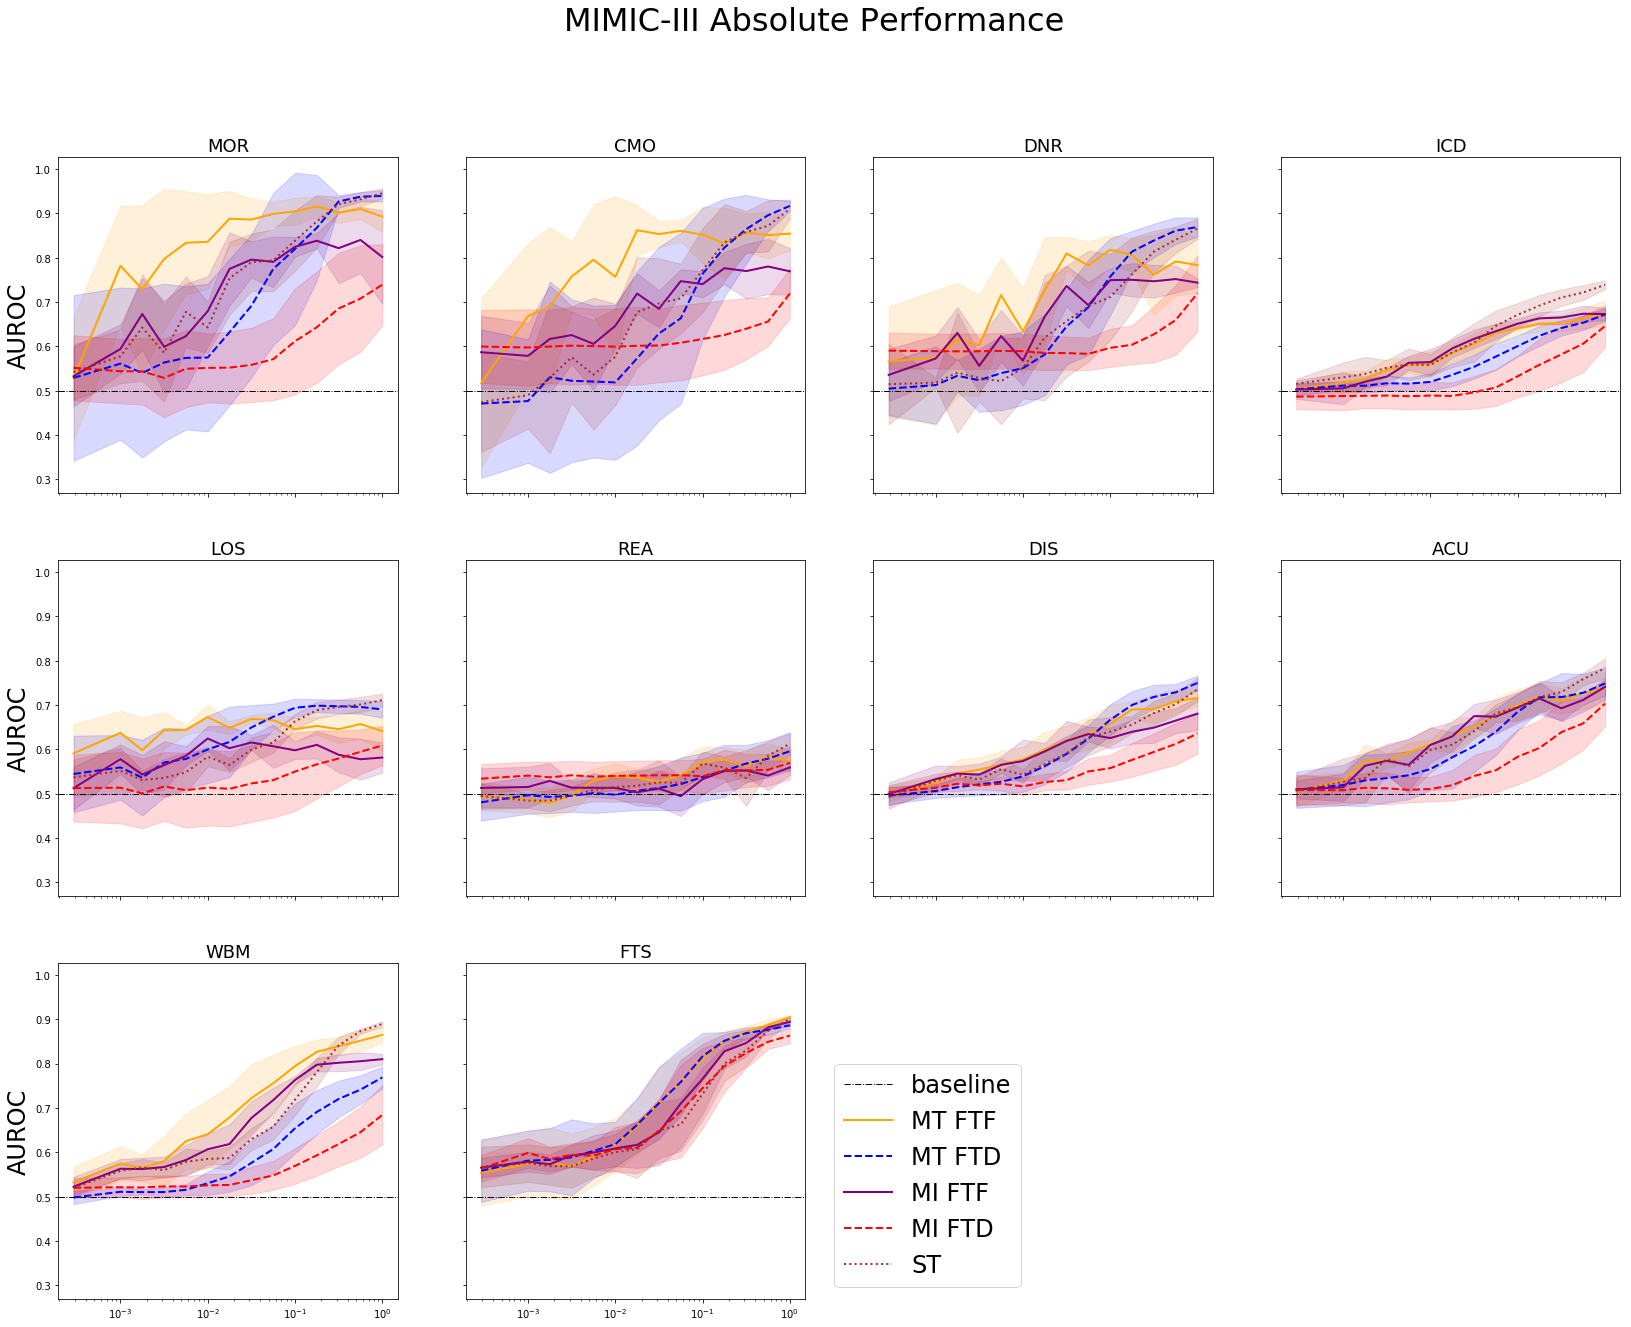

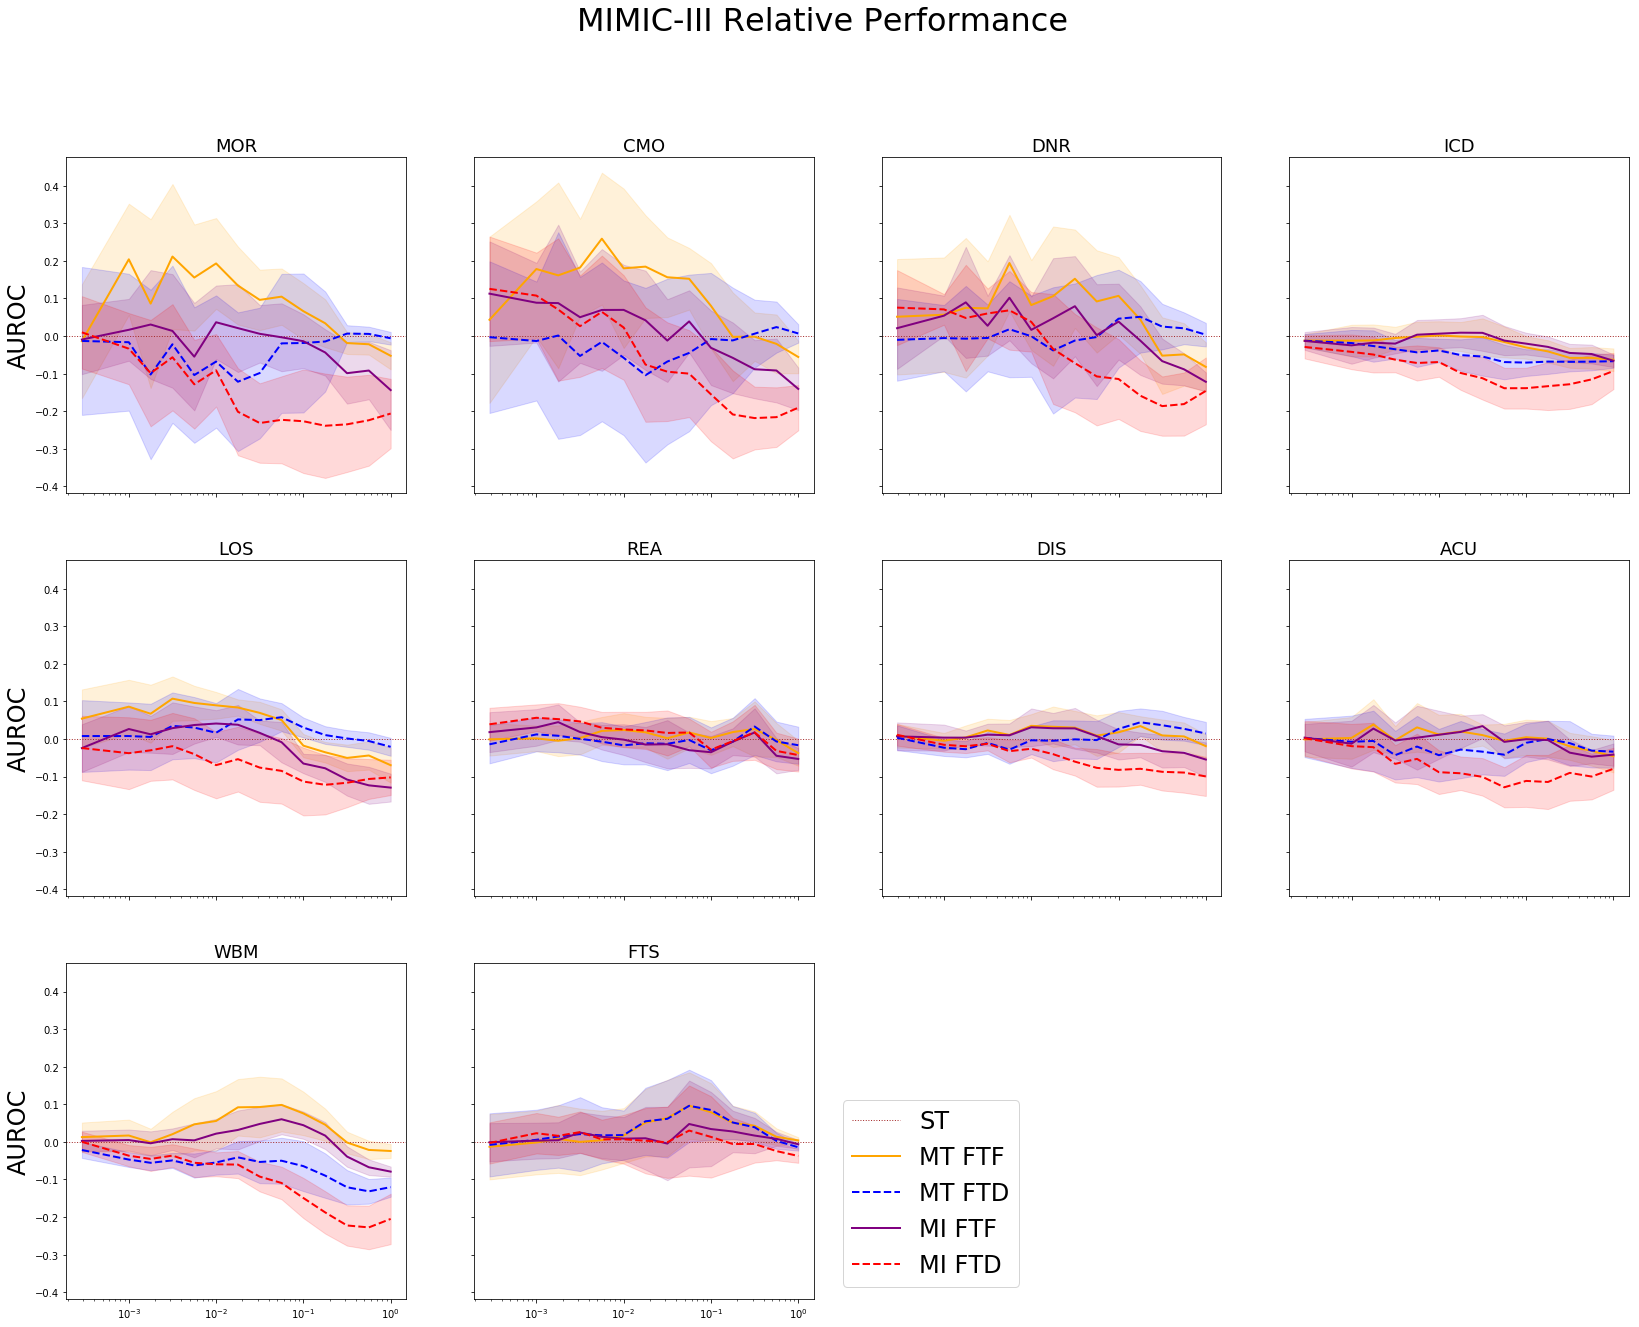

In [18]:
out_mimic = process_dataset(reorged_full, 'MIMIC-III', sp='test')

In [19]:
a = out_mimic[2].astype(int)
a.index = a.index.droplevel(1)
a.index.names = ['Task']
# a = reshape(a)
a = a['Full Data']
display(a)
print(a.to_latex())

PT/FT Regime,MI FTD,MI FTF,MT FTD,MT FTF,ST
Task,,,,,
ACU,5,5,6,6,5
FTS,5,5,6,6,5
ICD,5,5,6,6,5
DIS,5,5,6,6,5
DNR,5,5,6,6,5
REA,5,5,6,6,5
MOR,5,5,6,6,5
LOS,5,5,6,6,5
CMO,5,5,6,6,5


\begin{tabular}{lrrrrr}
\toprule
PT/FT Regime &  MI FTD &  MI FTF &  MT FTD &  MT FTF &  ST \\
Task &         &         &         &         &     \\
\midrule
ACU  &       5 &       5 &       6 &       6 &   5 \\
FTS  &       5 &       5 &       6 &       6 &   5 \\
ICD  &       5 &       5 &       6 &       6 &   5 \\
DIS  &       5 &       5 &       6 &       6 &   5 \\
DNR  &       5 &       5 &       6 &       6 &   5 \\
REA  &       5 &       5 &       6 &       6 &   5 \\
MOR  &       5 &       5 &       6 &       6 &   5 \\
LOS  &       5 &       5 &       6 &       6 &   5 \\
CMO  &       5 &       5 &       6 &       6 &   5 \\
WBM  &       5 &       5 &       6 &       6 &   5 \\
\bottomrule
\end{tabular}



Processing eICU
eICU FTD off target and PT off target do match for MT.
ERROR: eICU FTD off target and PT off target don't match for masked_imputation!
eICU PT on-target (ablated) task performance statistics:


eICU                                                  
           MT                 masked_imputation                
         mean count       std              mean count       std
ACU  0.497692   5.0  0.026364          0.502045   5.0  0.009480
DIS  0.494819   5.0  0.013222          0.499985   5.0  0.008422
MOR  0.479719   5.0  0.110107          0.521971   5.0  0.040535
LOS  0.487115   5.0  0.066871          0.501467   5.0  0.015045
WBM  0.503841   5.0  0.007062          0.517088   5.0  0.023642

eICU Final Manuscript Table and Counts:


Dataset Size    Few-shot (1%)                                    \
PT/FT Regime           MI FTD           MI FTF           MT FTD   
Task                                                              
ACU           $0.51 \pm 0.01$  $0.58 \pm 0.02$  $0.55 \pm 0.05$   
DIS           $0.51 \pm 0.01$  $0.56 \pm 0.01$  $0.53 \pm 0.03$   
MOR           $0.57 \pm 0.04$   $0.7 \pm 0.06$  $0.52 \pm 0.14$   
LOS           $0.51 \pm 0.02$  $0.55 \pm 0.02$  $0.53 \pm 0.06$   
WBM           $0.59 \pm 0.04$  $0.77 \pm 0.05$  $0.53 \pm 0.02$   

Dataset Size                                                  Few-shot (10%)  \
PT/FT Regime                        MT FTF               ST           MI FTD   
Task                                                                           
ACU           $\boldsymbol{0.62 \pm 0.02}$  $0.58 \pm 0.02$  $0.56 \pm 0.03$   
DIS           $\boldsymbol{0.58 \pm 0.01}$  $0.56 \pm 0.01$  $0.53 \pm 0.02$   
MOR            $\boldsymbol{0.8 \pm 0.02}$   $0.6 \pm 0.06$  $0.62 \pm 0.09$   
LOS           $\boldsymbol{0.59 \pm 0.02}$  $0.54 \pm 0.04$  $0.52 \pm 0.03$   
WBM            $\boldsymbol{0.8 \pm 0.05}$  $0.65 \pm 0.09$  $0.72 \pm 0.03$   

Dataset Size                                                 \
PT/FT Regime           MI FTF                        MT FTD   
Task                                                          
ACU           $0.63 \pm 0.02$  $\boldsymbol{0.67 \pm 0.03}$   
DIS            $0.6 \pm 0.01$               $0.61 \pm 0.04$   
MOR            $0.8 \pm 0.03$               $0.77 \pm 0.07$   
LOS            $0.6 \pm 0.03$               $0.61 \pm 0.02$   
WBM           $0.87 \pm 0.01$               $0.66 \pm 0.05$   

Dataset Size                                                       Full Data  \
PT/FT Regime                        MT FTF               ST           MI FTD   
Task                                                                           
ACU                        $0.64 \pm 0.02$  $0.64 \pm 0.01$  $0.62 \pm 0.02$   
DIS           $\boldsymbol{0.62 \pm 0.01}$  $0.61 \pm 0.01$  $0.58 \pm 0.03$   
MOR            $\boldsymbol{0.8 \pm 0.03}$  $0.77 \pm 0.03$  $0.72 \pm 0.07$   
LOS           $\boldsymbol{0.61 \pm 0.02}$   $0.61 \pm 0.0$  $0.54 \pm 0.04$   
WBM           $\boldsymbol{0.88 \pm 0.02}$  $0.82 \pm 0.05$  $0.79 \pm 0.04$   

Dataset Size                                                              \
PT/FT Regime                        MI FTF                        MT FTD   
Task                                                                       
ACU                        $0.66 \pm 0.01$   $\boldsymbol{0.7 \pm 0.02}$   
DIS                        $0.64 \pm 0.01$  $\boldsymbol{0.66 \pm 0.02}$   
MOR                        $0.83 \pm 0.01$  $\boldsymbol{0.86 \pm 0.01}$   
LOS                        $0.64 \pm 0.02$               $0.62 \pm 0.02$   
WBM           $\boldsymbol{0.91 \pm 0.01}$               $0.79 \pm 0.02$   

Dataset Size                                                
PT/FT Regime           MT FTF                           ST  
Task                                                        
ACU           $0.67 \pm 0.02$              $0.68 \pm 0.02$  
DIS           $0.64 \pm 0.01$               $0.65 \pm 0.0$  
MOR           $0.82 \pm 0.02$              $0.85 \pm 0.01$  
LOS           $0.63 \pm 0.05$  $\boldsymbol{0.65 \pm 0.0}$  
WBM           $0.91 \pm 0.01$               $0.9 \pm 0.02$

Dataset Size Few-shot (1%)                           Few-shot (10%)         \
PT/FT Regime        MI FTD MI FTF MT FTD MT FTF   ST         MI FTD MI FTF   
ACU count              5.0    5.0    5.0    5.0  5.0            5.0    5.0   
DIS count              5.0    5.0    5.0    5.0  5.0            5.0    5.0   
MOR count              5.0    5.0    5.0    5.0  5.0            5.0    5.0   
LOS count              5.0    5.0    5.0    5.0  5.0            5.0    5.0   
WBM count              5.0    5.0    5.0    5.0  5.0            5.0    5.0   

Dataset Size                    Full Data                            
PT/FT Regime MT FTD MT FTF   ST    MI FTD MI FTF MT FTD MT FTF   ST  
ACU count       5.0    5.0  5.0       5.0    5.0    5.0    5.0  5.0  
DIS count       5.0    5.0  5.0       5.0    5.0    5.0    5.0  5.0  
MOR count       5.0    5.0  5.0       5.0    5.0    5.0    5.0  5.0  
LOS count       5.0    5.0  5.0       5.0    5.0    5.0    5.0  5.0  
WBM count       5.0    5.0  5.0       5.0    5.0    5.0    5.0  5.0



(for copying to latex):
\begin{tabular}{llllllllllllllll}
\toprule
{} & \multicolumn{5}{l}{Few-shot (1\%)} & \multicolumn{5}{l}{Few-shot (10\%)} & \multicolumn{5}{l}{Full Data} \\
{} &           MI FTD &           MI FTF &           MT FTD &                        MT FTF &               ST &           MI FTD &           MI FTF &                        MT FTD &                        MT FTF &               ST &           MI FTD &                        MI FTF &                        MT FTD &           MT FTF &                           ST \\
    &                  &                  &                  &                               &                  &                  &                  &                               &                               &                  &                  &                               &                               &                  &                              \\
\midrule
ACU &  $0.51 \pm 0.01$ &  $0.58 \pm 0.02$ &  $0.55 \pm 0.05$ &  $\boldsy

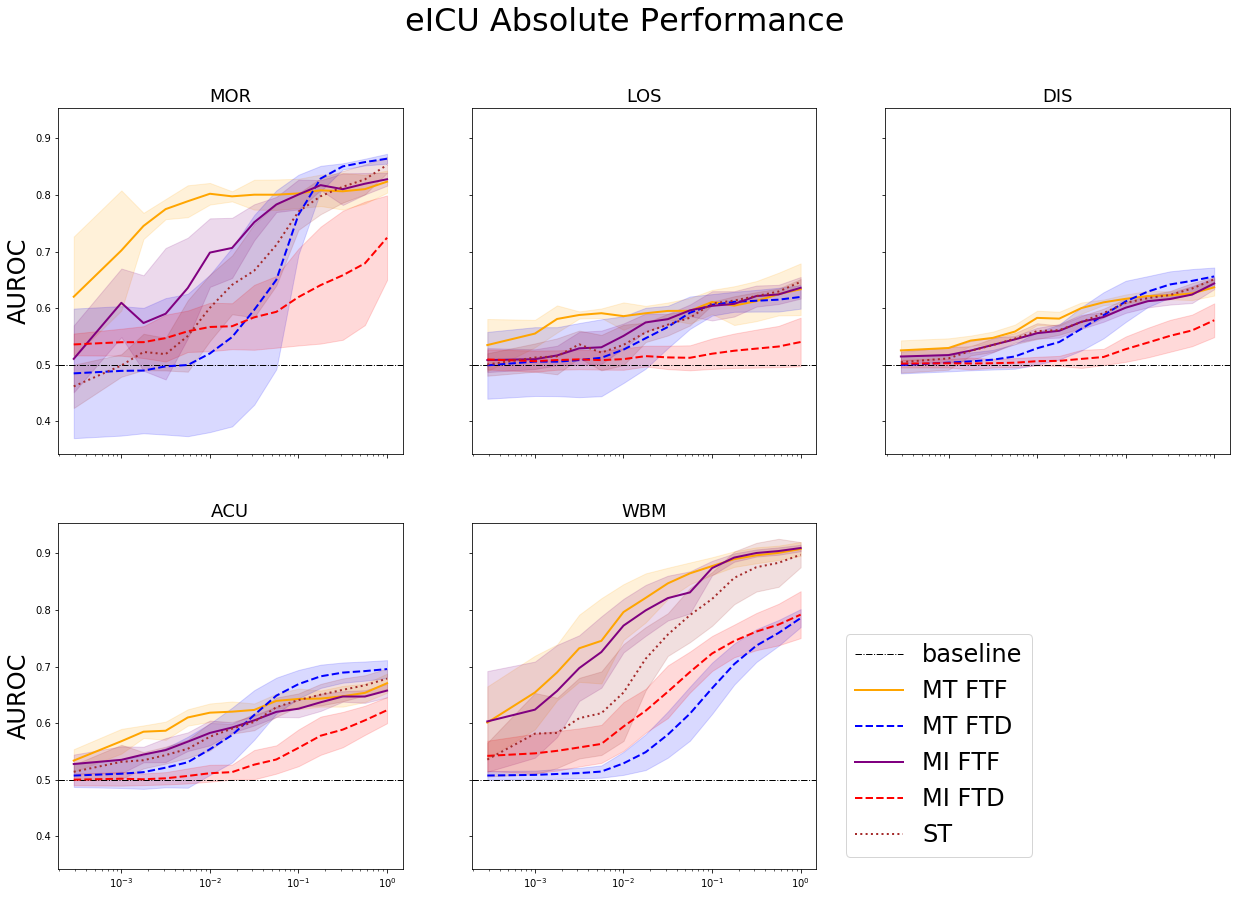

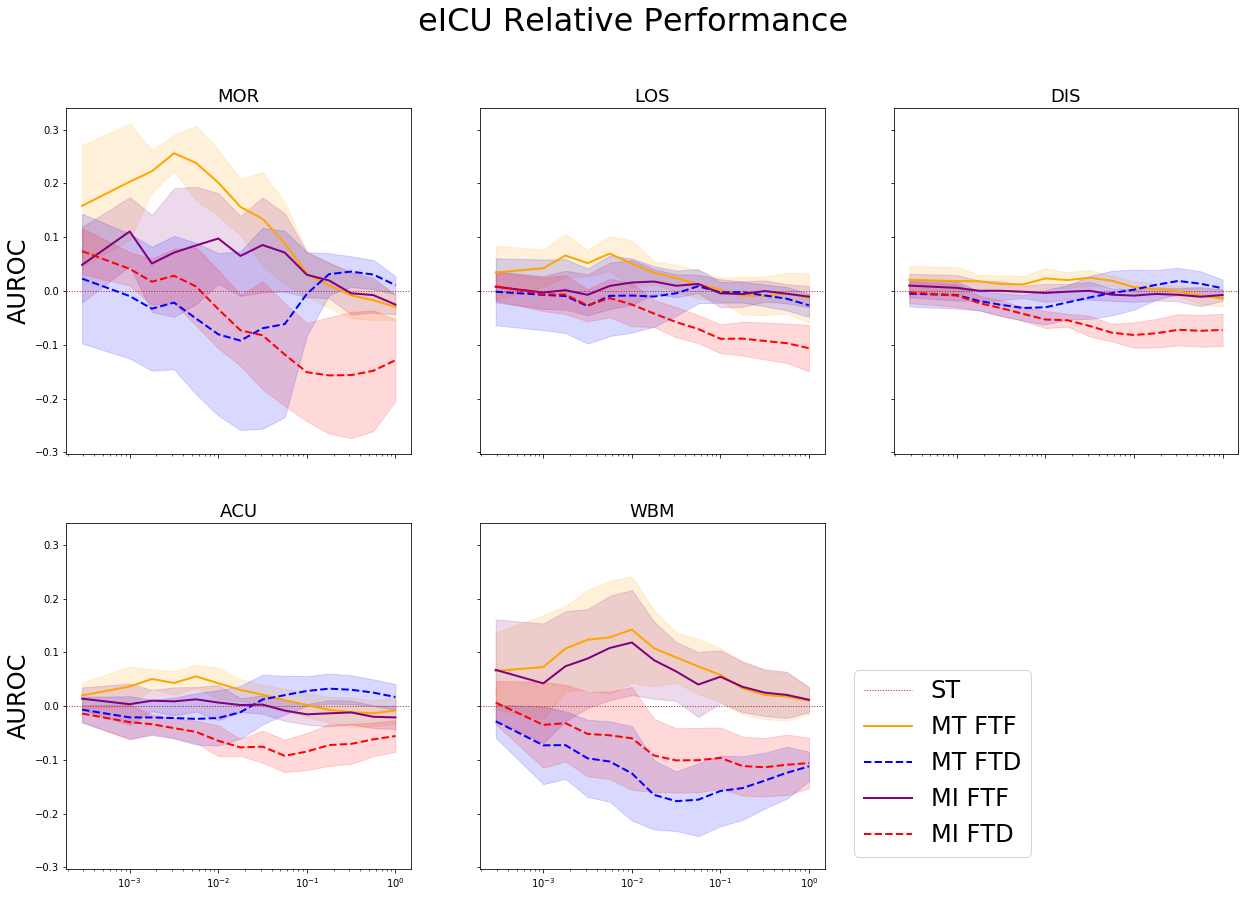

In [20]:
out_eicu = process_dataset(reorged_full, 'eICU', sp='test')

In [21]:
a = (out_eicu[2].astype(int))
a.index = a.index.droplevel(1)
a.index.names = ['Task']
# a = reshape(a)
a = a['Full Data']
display(a)
print(a.to_latex())

PT/FT Regime,MI FTD,MI FTF,MT FTD,MT FTF,ST
Task,,,,,
ACU,5,5,5,5,5
DIS,5,5,5,5,5
MOR,5,5,5,5,5
LOS,5,5,5,5,5
WBM,5,5,5,5,5


\begin{tabular}{lrrrrr}
\toprule
PT/FT Regime &  MI FTD &  MI FTF &  MT FTD &  MT FTF &  ST \\
Task &         &         &         &         &     \\
\midrule
ACU  &       5 &       5 &       5 &       5 &   5 \\
DIS  &       5 &       5 &       5 &       5 &   5 \\
MOR  &       5 &       5 &       5 &       5 &   5 \\
LOS  &       5 &       5 &       5 &       5 &   5 \\
WBM  &       5 &       5 &       5 &       5 &   5 \\
\bottomrule
\end{tabular}



In [22]:
joint_vertical = pd.concat(
    (reshape(out_mimic[1], add_dataset='MIMIC-III'), reshape(out_eicu[1], add_dataset='eICU')),
    axis=1
).fillna('')

sizes = list(set(joint_vertical.index.get_level_values('Dataset Size')))
get_frac = lambda x: 100 if '%' not in x else int(x.replace('Few-shot (', '').replace('%)', ''))
sizes = sorted(sizes, key=get_frac)
joint_vertical = joint_vertical.loc[
    [(s, t) for s in sizes for t in TASK_ORDER]
]

display(joint_vertical)
print(joint_vertical.to_latex(escape=False))

Dataset                                 MIMIC-III  \
PT/FT Regime                               MI FTD   
Dataset Size   Task                                 
Few-shot (1%)  MOR                $0.55 \pm 0.08$   
               CMO                 $0.6 \pm 0.09$   
               DNR                $0.59 \pm 0.04$   
               ICD                $0.49 \pm 0.03$   
               LOS                $0.51 \pm 0.09$   
               REA   $\boldsymbol{0.54 \pm 0.03}$   
               DIS                $0.52 \pm 0.02$   
               ACU                $0.51 \pm 0.03$   
               WBM                $0.53 \pm 0.03$   
               FTS                $0.61 \pm 0.05$   
Few-shot (10%) MOR                $0.61 \pm 0.12$   
               CMO                $0.62 \pm 0.08$   
               DNR                 $0.6 \pm 0.04$   
               ICD                $0.53 \pm 0.05$   
               LOS                $0.55 \pm 0.09$   
               REA                $0.54 \pm 0.04$   
               DIS                $0.56 \pm 0.03$   
               ACU                $0.58 \pm 0.06$   
               WBM                $0.57 \pm 0.04$   
               FTS                $0.74 \pm 0.09$   
Full Data      MOR                $0.74 \pm 0.09$   
               CMO                $0.72 \pm 0.06$   
               DNR                $0.72 \pm 0.09$   
               ICD                $0.65 \pm 0.05$   
               LOS                $0.61 \pm 0.04$   
               REA                $0.57 \pm 0.04$   
               DIS                $0.64 \pm 0.05$   
               ACU                 $0.7 \pm 0.05$   
               WBM                $0.68 \pm 0.07$   
               FTS                $0.86 \pm 0.02$   

Dataset                                            \
PT/FT Regime                               MI FTF   
Dataset Size   Task                                 
Few-shot (1%)  MOR                $0.68 \pm 0.08$   
               CMO                $0.65 \pm 0.05$   
               DNR                $0.57 \pm 0.06$   
               ICD   $\boldsymbol{0.56 \pm 0.03}$   
               LOS                $0.62 \pm 0.03$   
               REA                $0.51 \pm 0.02$   
               DIS                $0.57 \pm 0.05$   
               ACU                $0.61 \pm 0.04$   
               WBM                $0.61 \pm 0.03$   
               FTS                $0.61 \pm 0.04$   
Few-shot (10%) MOR                $0.82 \pm 0.02$   
               CMO                $0.74 \pm 0.03$   
               DNR                $0.75 \pm 0.03$   
               ICD                $0.65 \pm 0.01$   
               LOS                 $0.6 \pm 0.02$   
               REA                $0.53 \pm 0.03$   
               DIS                $0.63 \pm 0.02$   
               ACU                $0.69 \pm 0.03$   
               WBM                $0.76 \pm 0.01$   
               FTS                $0.77 \pm 0.08$   
Full Data      MOR                 $0.8 \pm 0.11$   
               CMO                $0.77 \pm 0.05$   
               DNR                $0.74 \pm 0.01$   
               ICD                $0.67 \pm 0.01$   
               LOS                $0.58 \pm 0.03$   
               REA                $0.56 \pm 0.02$   
               DIS                $0.68 \pm 0.04$   
               ACU                $0.74 \pm 0.02$   
               WBM                $0.81 \pm 0.01$   
               FTS                $0.89 \pm 0.01$   

Dataset                                            \
PT/FT Regime                               MT FTD   
Dataset Size   Task                                 
Few-shot (1%)  MOR                $0.57 \pm 0.17$   
               CMO                $0.52 \pm 0.17$   
               DNR                $0.55 \pm 0.08$   
               ICD                $0.52 \pm 0.02$   
               LOS                 $0.6 \pm 0.08$   
               REA                 $0.5 \pm 0.04$   
               DIS     

\begin{tabular}{llllllllllll}
\toprule
          & Dataset & \multicolumn{5}{l}{MIMIC-III} & \multicolumn{5}{l}{eICU} \\
          & PT/FT Regime &                        MI FTD &                        MI FTF &                        MT FTD &                        MT FTF &                            ST &           MI FTD &                        MI FTF &                        MT FTD &                        MT FTF &                           ST \\
Dataset Size & Task &                               &                               &                               &                               &                               &                  &                               &                               &                               &                              \\
\midrule
Few-shot (1%) & MOR &               $0.55 \pm 0.08$ &               $0.68 \pm 0.08$ &               $0.57 \pm 0.17$ &  $\boldsymbol{0.84 \pm 0.11}$ &               $0.64 \pm 0.06$ &  $0.57 \pm 0.04$ &       

In [23]:
def restricted_plot(
    all_dfs_by_dataset, metric, tasks = ('MOR', 'WBM', 'ACU'),
    do_rel=False,
    include_FTD_in_winners_plot=True,
    include_FTD_in_raw_plot=False,
):
    assert type(all_dfs_by_dataset) is dict, "Wrong all_dfs type!"
    for k, vv in all_dfs_by_dataset.items():
        if type(vv) in (list, tuple): 
            try:
                vv = {k: v for k, v in vv}
                all_dfs_by_dataset[k] = vv
            except Exception as e:
                print(all_dfs)
                print(type(all_dfs))
                for i in all_dfs: 
                    print(type(i))
                    if type(i) in (list, tuple): print(len(i))
                raise

        assert type(vv) is dict, "Wrong all_dfs type!"
    
    agg_dfs_by_dataset = {d: {k: {} for k in all_dfs} for d, all_dfs in all_dfs_by_dataset.items()}
    for dataset, all_dfs in all_dfs_by_dataset.items():
        for k, df in all_dfs.items():
            for agg in ('mean', 'std'):
                agg_df = df.loc[idx[:, agg], :]
                agg_df.index = agg_df.index.droplevel(1)
                agg_dfs_by_dataset[dataset][k][agg] = agg_df
    
    dataset_fractions = {d: list(agg['MT FTF']['mean'].columns) for d, agg in agg_dfs_by_dataset.items()}
    
    N_tasks = len(tasks)
    N_datasets = len(agg_dfs_by_dataset)
    
    W = N_tasks + 1
    H = N_datasets + 1
    
    fig = plt.figure(figsize=(W*7, (H*7)*0.7))
    winners_axes = fig.subplots(
        N_datasets, 1, sharex=True, sharey=True,
        gridspec_kw=dict(left=0.08, right=0.28, wspace=0.2, bottom=0.1)
    )
    tasks_axes = fig.subplots(
        N_datasets, N_tasks, sharex=True, sharey=True,
        gridspec_kw=dict(left=0.35, right=0.95, wspace=0.2, bottom=0.1)
    )
    legend_ax   = fig.subplots(1, 1, gridspec_kw=dict(top=0.05, bottom=0))
    
    datasets = [t for t in ['MIMIC-III', 'eICU'] if t in agg_dfs_by_dataset]
    assert len(datasets) == N_datasets
    assert len(winners_axes) == N_datasets
    assert len(tasks_axes) == N_datasets
    
    handles_by_label = {}
    for data_idx, dataset in enumerate(datasets):
        agg_dfs = agg_dfs_by_dataset[dataset]

        X = dataset_fractions[dataset]
        
        ## First plot:
        winners_by_mode = {mode: np.array([0 for _ in X]) for mode in agg_dfs}
        
        # TODO: there's a better way to do this.
        tasks_obs = set(agg_dfs['ST']['mean'].index)
        for i, frac in enumerate(X):
            for task in tasks_obs:
                winner, best_perf = None, 0
                
                for mode, aggs in agg_dfs.items():
                    perf = aggs['mean'].loc[task, frac]
                    if perf > best_perf: winner, best_perf = mode, perf
                
                winners_by_mode[winner][i] += 1
                
        winners_by_mode = {mode: winners / len(tasks_obs) for mode, winners in winners_by_mode.items()}

        ax = winners_axes[data_idx]
        
        ax.annotate(dataset, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 30, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='40', ha='right', va='center')
        
        ax.set_xscale('log')
        if dataset == datasets[-1]: ax.set_xlabel('FT Dataset Size (%)', fontsize=28)
        ax.set_ylabel("% Best Performance", fontsize=28)
        ax.set_ylim(bottom=-0.05, top=1.05)
        if dataset == datasets[0]: ax.set_title("% of Tasks on which\nModel Performs Best\n", fontsize=40)
        
        for k, Y in winners_by_mode.items():
            if not include_FTD_in_winners_plot and 'FTD' in k: continue
            
            linestyle = LINESTYLES[k if k in LINESTYLES else k.split()[1]]
            color     = LINECOLORS[k if k in LINECOLORS else k.split()[1]]

            handles_by_label[k], = ax.plot(X, Y, linestyle=linestyle, color=color, linewidth=2, label=k)        
        
        ## Rest of plots
        tasks_axes_row = tasks_axes[data_idx]
        min_auroc, max_auroc = 1, 0
        ts = [t for t in tasks if t in tasks_obs] if do_rel else tasks
        for i, (task, ax) in enumerate(zip(ts, tasks_axes_row)):
            if dataset == datasets[0]: ax.set_title(f"{task}\n", fontsize=40)
            ax.set_xscale('log')
            if dataset == datasets[-1]: ax.set_xlabel('FT Dataset Size (Fraction)', fontsize=28)
            if i == 0: ax.set_ylabel('AUROC', fontsize=28)

            if do_rel: base_val, base_style_key = 0, 'ST'
            else: base_val, base_style_key = 0.5 if metric == 'AUROC' else 0, 'baseline'

            handles_by_label[base_style_key] = ax.axhline(
                y=base_val, linestyle=LINESTYLES[base_style_key], linewidth=1,
                color=LINECOLORS[base_style_key], label=base_style_key
            )


            if do_rel:
                ST_means, ST_stds = agg_dfs['ST']['mean'], agg_dfs['ST']['std']

            for k, aggs in agg_dfs.items():
                if do_rel and k == 'ST': continue
                if not include_FTD_in_raw_plot and 'FTD' in k: continue
            
                means, stds = aggs['mean'], aggs['std']

                if task not in means.index: continue
                if do_rel and task not in ST_means.index: continue

                Y     = means.loc[task, X]
                if do_rel: Y -= ST_means.loc[task, X]

                if do_rel: Y_err = np.sqrt(stds.loc[task, X]**2 + ST_stds.loc[task, X]**2)
                else: Y_err = stds.loc[task, X]

                linestyle = LINESTYLES[k if k in LINESTYLES else k.split()[1]]
                color     = LINECOLORS[k if k in LINECOLORS else k.split()[1]]

                min_auroc = min(min_auroc, min(Y-Y_err))
                max_auroc = max(max_auroc, max(Y+Y_err))
                handles_by_label[k], = ax.plot(
                    X, Y, linestyle=linestyle, color=color, linewidth=2, label=k
                )
                ax.fill_between(X, Y-Y_err, Y+Y_err, color=color, alpha=0.15)

#             if i == (N_tasks - 1) and dataset == datasets[-1]:
#                 ax.legend(fontsize=28, bbox_to_anchor=(1.05, 0), loc='lower left')
                
        for ax in tasks_axes_row:
            ax.set_ylim(bottom=min_auroc-0.05, top=1)
            
    labels = [
        l for l in ('baseline', 'ST', 'MT FTF', 'MT FTD', 'MI FTF', 'MI FTD') if l in handles_by_label
    ]
    handles = [handles_by_label[l] for l in labels]
    legend_ax.legend(fontsize=28, handles=handles, labels=labels, loc='upper center', ncol=len(handles))
    legend_ax.set_axis_off()
            
    return fig

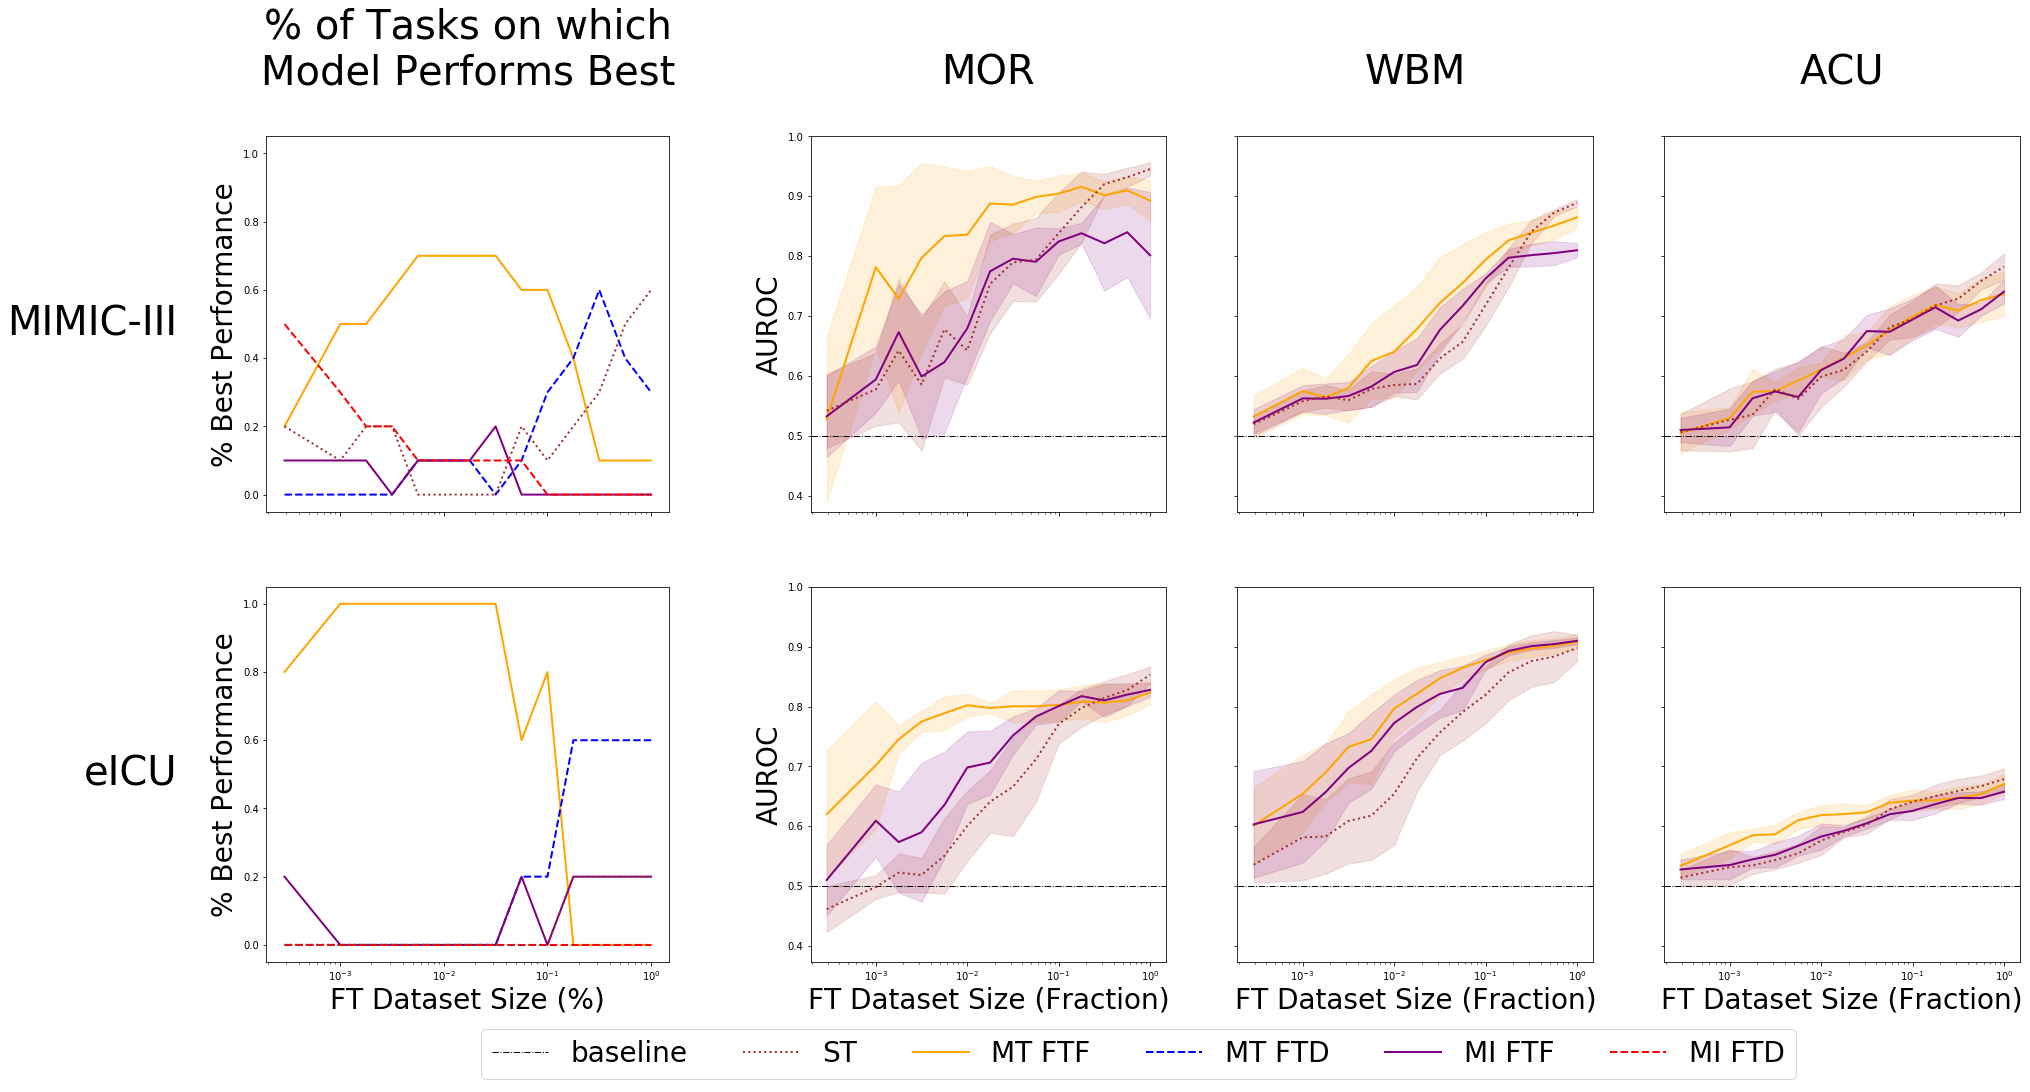

In [24]:
fig = restricted_plot({'MIMIC-III': out_mimic[0], 'eICU': out_eicu[0]}, 'AUROC')

## Negative Transfer Analysis

In [25]:
def get_negative_transfer_studies(
    full, hyperparameter_search_results, sp='test', metric='AUROC', figscale=9, include_err=False
):
    assert sp in ('tuning', 'test')

    MT_PT_results = {}
    full_MT_results = {}
    deltas = {}
        
    fig, axes_by_dataset = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, figsize=(2*figscale, 2*figscale)
    )
        
    for dataset, (ax_by_meas, ax_by_incl) in zip(('MIMIC-III', 'eICU'), axes_by_dataset):
        ax_by_meas.set_title(f"{dataset} Performance when\nOther Tasks Withheld", fontsize=22)
        ax_by_meas.set_ylabel(f'Task withheld - Original (metric)', fontsize=18)
        ax_by_incl.set_title(f"{dataset} Task Inclusion Value", fontsize=22)
        ax_by_incl.set_ylabel(f'{metric} Improvement When\nTask Included', fontsize=18)
        
        D0 = full[dataset]['MT']['gru']
        hyp_D = hyperparameter_search_results[dataset]['MT']['gru']['results']
        
        MT_PT_results[dataset] = {}
        full_MT_results[dataset] = {}
        deltas[dataset] = []
        agg_deltas = None
        
        for rotation, result_D in zip(D0['rotations'], D0['results']):
            experiment_keys = result_D['exp_keys']
            assert len(experiment_keys) == 1
            exp_key = list(experiment_keys)[0]
            
            full_MT_results[dataset][rotation] = hyp_D[rotation]['results'][exp_key][1][(sp, metric)].copy()
            tasks = [t for t in TASK_ORDER if t in list(full_MT_results[dataset][rotation].index)]
            
            full_MT_results[dataset][rotation] = full_MT_results[dataset][rotation].loc[tasks]

            all_results = {}
            result_D = result_D['results'][0]['results']
            for task, task_D in result_D.items():
                task = ABLATIONS_TO_REPORTING_MAP[task]
                
                task_results = task_D['PT'][f'{sp} manuscript ({metric})'].copy()
                task_results[task] = np.NaN # we only want off-target PT results here.
                all_results[task] = task_results.loc[tasks]
            
            all_results = pd.DataFrame(all_results).loc[tasks, tasks]
            all_results.index.names = ['Measured Task']
            all_results.columns.names = ['Omitted Task']
            
            MT_PT_results[dataset][rotation] = all_results
            
            delta = (MT_PT_results[dataset][rotation].T - full_MT_results[dataset][rotation]).T
            deltas[dataset].append(delta)
            
#             delta = delta.copy().applymap(lambda x: [] if np.isnan(x) else [x])
#             if agg_deltas is None: agg_deltas = delta
#             else agg_deltas += delta
        
        X = np.arange(len(tasks))
        # By measured data
        Ys_by_task_measured = {t: {tt: [] for tt in tasks} for t in tasks}
        Ys_by_task_included = {t: {tt: [] for tt in tasks} for t in tasks}
        for t in tasks:
            task_perf_by_task_omitted = Ys_by_task_measured[t]
            task_inclusion_value_by_task_measured = Ys_by_task_included[t]
            
            for delta in deltas[dataset]:
                measuring_t = delta.loc[t, :].to_dict()
                
                # Negating to measure value of including, not omitted
                including_t = (-delta.loc[:, t]).to_dict()
                
                for task_omitted, perf in measuring_t.items():
                    if not np.isnan(perf): task_perf_by_task_omitted[task_omitted].append(perf)
                for task_measured, perf in including_t.items():
                    if not np.isnan(perf): task_inclusion_value_by_task_measured[task_measured].append(perf)
        
        Ys_by_task_measured_arr = [
            list(itertools.chain.from_iterable(Ys_by_task_measured[t].values())) for t in tasks
        ]
        Ys_by_task_included_arr = [
            list(itertools.chain.from_iterable(Ys_by_task_included[t].values())) for t in tasks
        ]
        
        # Violinplots
        ax_by_meas.violinplot(
            dataset   = Ys_by_task_measured_arr,
            positions = X, showmeans=True
        )
        ax_by_incl.violinplot(
            dataset   = Ys_by_task_included_arr,
            positions = X, showmeans=True
        )
        
        for ax in (ax_by_meas, ax_by_incl):
            ax.set_xticks(X)
            ax.set_xticklabels(tasks, rotation=90, fontsize=18)
            no_change_handle = ax.axhline(0, color='black', linestyle='dashed')
        
        # Scatter plots
        # by_meas_X, by_meas_Y, by_meas_err, by_meas_C
        scatter_by_meas, scatter_by_incl = [], []
        for (X_meas, task_measured) in zip(X, tasks):
            for (X_incl, task_included) in zip(X, tasks):
                Ys_meas = Ys_by_task_measured[task_measured][task_included]
                scatter_by_meas.append((
                    X_meas, np.mean(Ys_meas), np.std(Ys_meas), COLORS[task_included]
                ))
                
                Ys_incl = Ys_by_task_included[task_included][task_measured]
                scatter_by_incl.append((
                    X_incl, np.mean(Ys_incl), np.std(Ys_incl), COLORS[task_measured]
                ))
        
        by_meas_X, by_meas_Y, by_meas_err, by_meas_C = zip(*scatter_by_meas)
        assert not include_err, "not supported yet."
        ax_by_meas.scatter(by_meas_X, by_meas_Y, c=by_meas_C, zorder=10, s=100)
        
        by_incl_X, by_incl_Y, by_incl_err, by_incl_C = zip(*scatter_by_incl)
        ax_by_incl.scatter(by_incl_X, by_incl_Y, c=by_incl_C, zorder=10, s=100)
        
    handles, labels = [], []
    for task, color in COLORS.items():
        h = Line2D([0], [0], color='w', marker='o', markerfacecolor=color, markersize=figscale)
        handles.append(h)
        labels.append(f"{task} omitted/measured")
        
    handles.append(no_change_handle)
    labels.append("No change")
            
    axes_by_dataset[0][1].legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    plt.tight_layout()
    
    return MT_PT_results, full_MT_results, deltas

/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


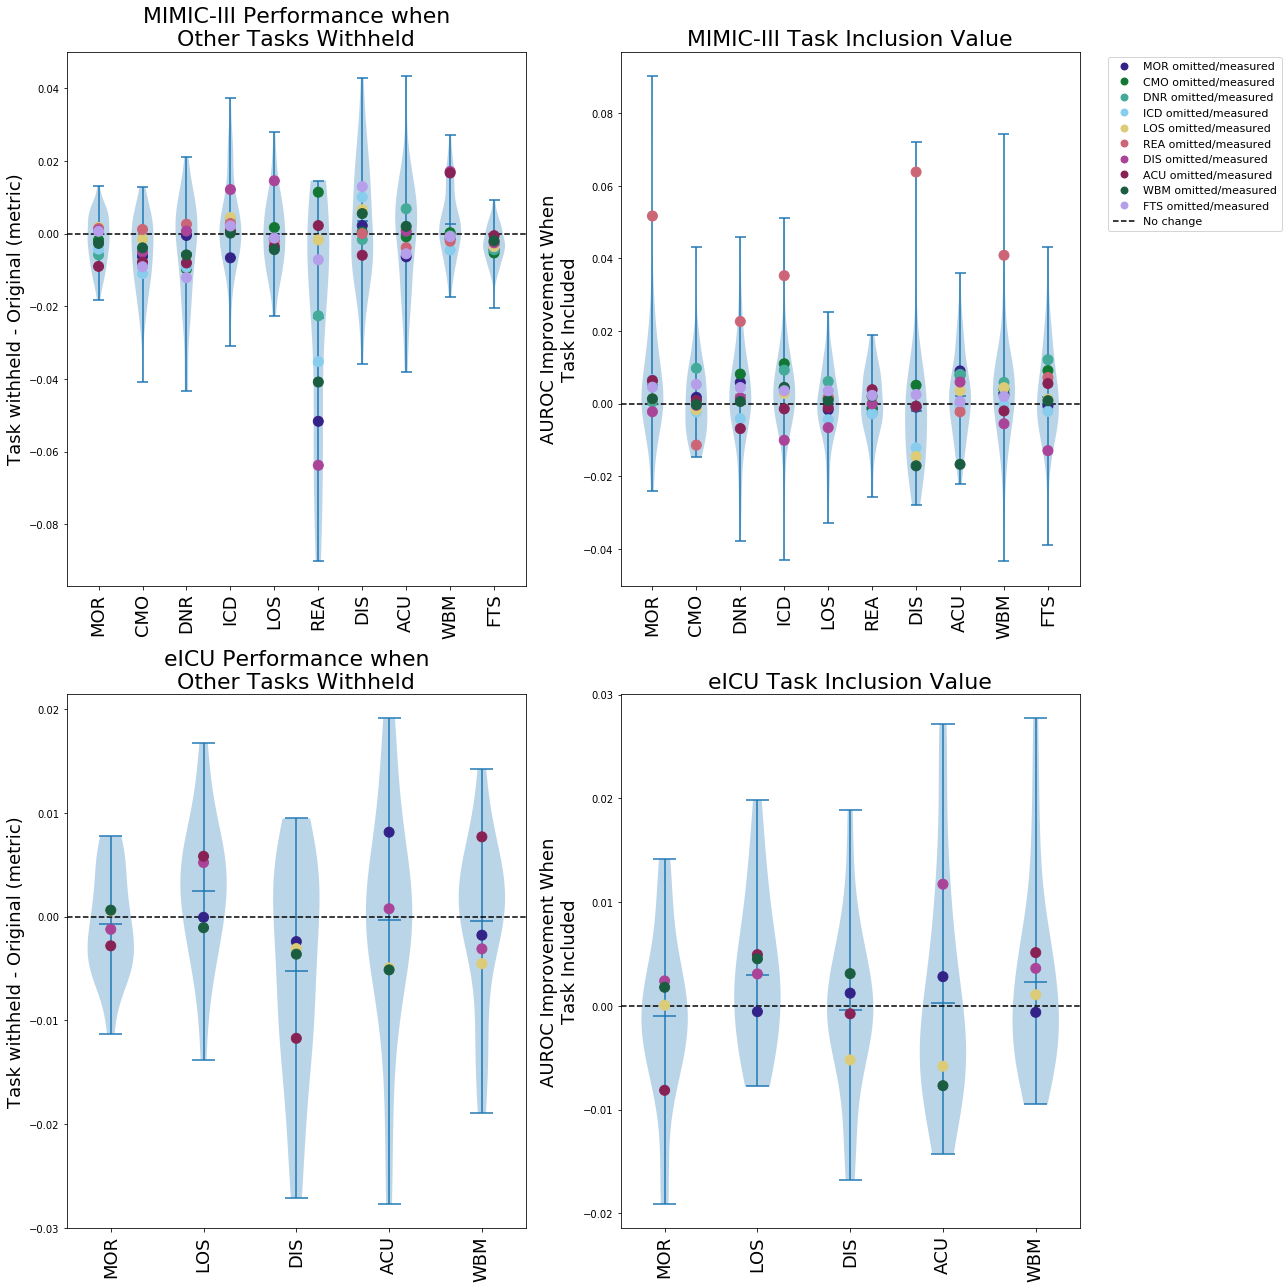

In [26]:
MT_PT, full_MT, deltas = get_negative_transfer_studies(full, hyperparameter_search_results, sp='test')

In [27]:
def get_negative_transfer_studies_hist(
    full, hyperparameter_search_results, sp='test', metric='AUROC', figscale=10, include_err=False
):
    assert sp in ('tuning', 'test')

    MT_PT_results = {}
    full_MT_results = {}
    deltas = {}
    
    hist_left = 0.05
    hist_right = 0.15
    meas_left = 0.155
    meas_right = 0.505
    incl_left = 0.605
    incl_right = 0.955
    
    eicu_bottom = 0.1
    eicu_top = 0.455
    mimic_bottom = 0.555
    mimic_top = 0.9
    
    fig = plt.figure(figsize=(2*figscale, 2*figscale))
    
    ax_mimic_hist = fig.add_axes((hist_left, mimic_bottom, (hist_right-hist_left), (mimic_top-mimic_bottom)))
    ax_eicu_hist = fig.add_axes((hist_left, eicu_bottom, (hist_right-hist_left), (eicu_top-eicu_bottom)))
    ax_mimic_meas = fig.add_axes((meas_left, mimic_bottom, (meas_right-meas_left), (mimic_top-mimic_bottom)))
    ax_eicu_meas = fig.add_axes((meas_left, eicu_bottom, (meas_right-meas_left), (eicu_top-eicu_bottom)))
    ax_mimic_incl = fig.add_axes((incl_left, mimic_bottom, (incl_right-incl_left), (mimic_top-mimic_bottom)))
    ax_eicu_incl = fig.add_axes((incl_left, eicu_bottom, (incl_right-incl_left), (eicu_top-eicu_bottom)))

    axes_by_dataset = [(ax_mimic_meas, ax_mimic_incl), (ax_eicu_meas, ax_eicu_incl)]    

    for dataset, (ax_by_meas, ax_by_incl), ax_hist in zip(
        ('MIMIC-III', 'eICU'), axes_by_dataset, (ax_mimic_hist, ax_eicu_hist)
    ):
        ax_by_meas.set_title(f"{dataset} Performance when\nOther Tasks Withheld", fontsize=22)
        ax_hist.set_ylabel(f'Task withheld - Original (metric)', fontsize=18)
        ax_by_meas.tick_params(axis="y", labelleft=False)
        
        ax_by_incl.set_title(f"{dataset} Task Inclusion Value", fontsize=22)
        ax_by_incl.set_ylabel(f'{metric} Improvement When\nTask Included', fontsize=18)
        
        D0 = full[dataset]['MT']['gru']
        hyp_D = hyperparameter_search_results[dataset]['MT']['gru']['results']
        
        MT_PT_results[dataset] = {}
        full_MT_results[dataset] = {}
        deltas[dataset] = []
        agg_deltas = None
        
        for rotation, result_D in zip(D0['rotations'], D0['results']):
            experiment_keys = result_D['exp_keys']
            assert len(experiment_keys) == 1
            exp_key = list(experiment_keys)[0]
            
            full_MT_results[dataset][rotation] = hyp_D[rotation]['results'][exp_key][1][(sp, metric)].copy()
            tasks = [t for t in TASK_ORDER if t in list(full_MT_results[dataset][rotation].index)]
            
            full_MT_results[dataset][rotation] = full_MT_results[dataset][rotation].loc[tasks]

            all_results = {}
            result_D = result_D['results'][0]['results']
            for task, task_D in result_D.items():
                task = ABLATIONS_TO_REPORTING_MAP[task]
                
                task_results = task_D['PT'][f'{sp} manuscript ({metric})'].copy()
                task_results[task] = np.NaN # we only want off-target PT results here.
                all_results[task] = task_results.loc[tasks]
            
            all_results = pd.DataFrame(all_results).loc[tasks, tasks]
            all_results.index.names = ['Measured Task']
            all_results.columns.names = ['Omitted Task']
            
            MT_PT_results[dataset][rotation] = all_results
            
            delta = (MT_PT_results[dataset][rotation].T - full_MT_results[dataset][rotation]).T
            deltas[dataset].append(delta)
            
#             delta = delta.copy().applymap(lambda x: [] if np.isnan(x) else [x])
#             if agg_deltas is None: agg_deltas = delta
#             else agg_deltas += delta
        
        X = np.arange(len(tasks))
        # By measured data
        Ys_by_task_measured = {t: {tt: [] for tt in tasks} for t in tasks}
        Ys_by_task_included = {t: {tt: [] for tt in tasks} for t in tasks}
        for t in tasks:
            task_perf_by_task_omitted = Ys_by_task_measured[t]
            task_inclusion_value_by_task_measured = Ys_by_task_included[t]
            
            for delta in deltas[dataset]:
                measuring_t = delta.loc[t, :].to_dict()
                
                # Negating to measure value of including, not omitted
                including_t = (-delta.loc[:, t]).to_dict()
                
                for task_omitted, perf in measuring_t.items():
                    if not np.isnan(perf): task_perf_by_task_omitted[task_omitted].append(perf)
                for task_measured, perf in including_t.items():
                    if not np.isnan(perf): task_inclusion_value_by_task_measured[task_measured].append(perf)
        
        Ys_by_task_measured_arr = [
            list(itertools.chain.from_iterable(Ys_by_task_measured[t].values())) for t in tasks
        ]
        Ys_by_task_included_arr = [
            list(itertools.chain.from_iterable(Ys_by_task_included[t].values())) for t in tasks
        ]
        
        # Histogram
        ax_hist.hist(
            list(itertools.chain.from_iterable(Ys_by_task_measured_arr)), bins=100, orientation='horizontal',
            alpha=0.4
        )
        ax_hist.axhline(0, color='black', linestyle='dashed')
        ax_hist.set_xlim(ax_hist.get_xlim()[::-1])
        
        # Violinplots
        ax_by_meas.violinplot(
            dataset   = Ys_by_task_measured_arr,
            positions = X, showmeans=True
        )
        ax_by_incl.violinplot(
            dataset   = Ys_by_task_included_arr,
            positions = X, showmeans=True
        )
        
        for ax in (ax_by_meas, ax_by_incl):
            ax.set_xticks(X)
            ax.set_xticklabels(tasks, rotation=90, fontsize=18)
            no_change_handle = ax.axhline(0, color='black', linestyle='dashed')
        
        # Scatter plots
        # by_meas_X, by_meas_Y, by_meas_err, by_meas_C
        scatter_by_meas, scatter_by_incl = [], []
        for (X_meas, task_measured) in zip(X, tasks):
            for (X_incl, task_included) in zip(X, tasks):
                Ys_meas = Ys_by_task_measured[task_measured][task_included]
                scatter_by_meas.append((
                    X_meas, np.mean(Ys_meas), np.std(Ys_meas), COLORS[task_included]
                ))
                
                Ys_incl = Ys_by_task_included[task_included][task_measured]
                scatter_by_incl.append((
                    X_incl, np.mean(Ys_incl), np.std(Ys_incl), COLORS[task_measured]
                ))
        
        by_meas_X, by_meas_Y, by_meas_err, by_meas_C = zip(*scatter_by_meas)
        assert not include_err, "not supported yet."
        ax_by_meas.scatter(by_meas_X, by_meas_Y, c=by_meas_C, zorder=10, s=100)
        
        by_incl_X, by_incl_Y, by_incl_err, by_incl_C = zip(*scatter_by_incl)
        ax_by_incl.scatter(by_incl_X, by_incl_Y, c=by_incl_C, zorder=10, s=100)
        
    handles, labels = [], []
    for task, color in COLORS.items():
        h = Line2D([0], [0], color='w', marker='o', markerfacecolor=color, markersize=figscale)
        handles.append(h)
        labels.append(f"{task} omitted/measured")
        
    handles.append(no_change_handle)
    labels.append("No change")
            
    axes_by_dataset[0][1].legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    plt.tight_layout()
    
    return MT_PT_results, full_MT_results, deltas

/crimea/conda_envs/latent_patient_trajectories/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


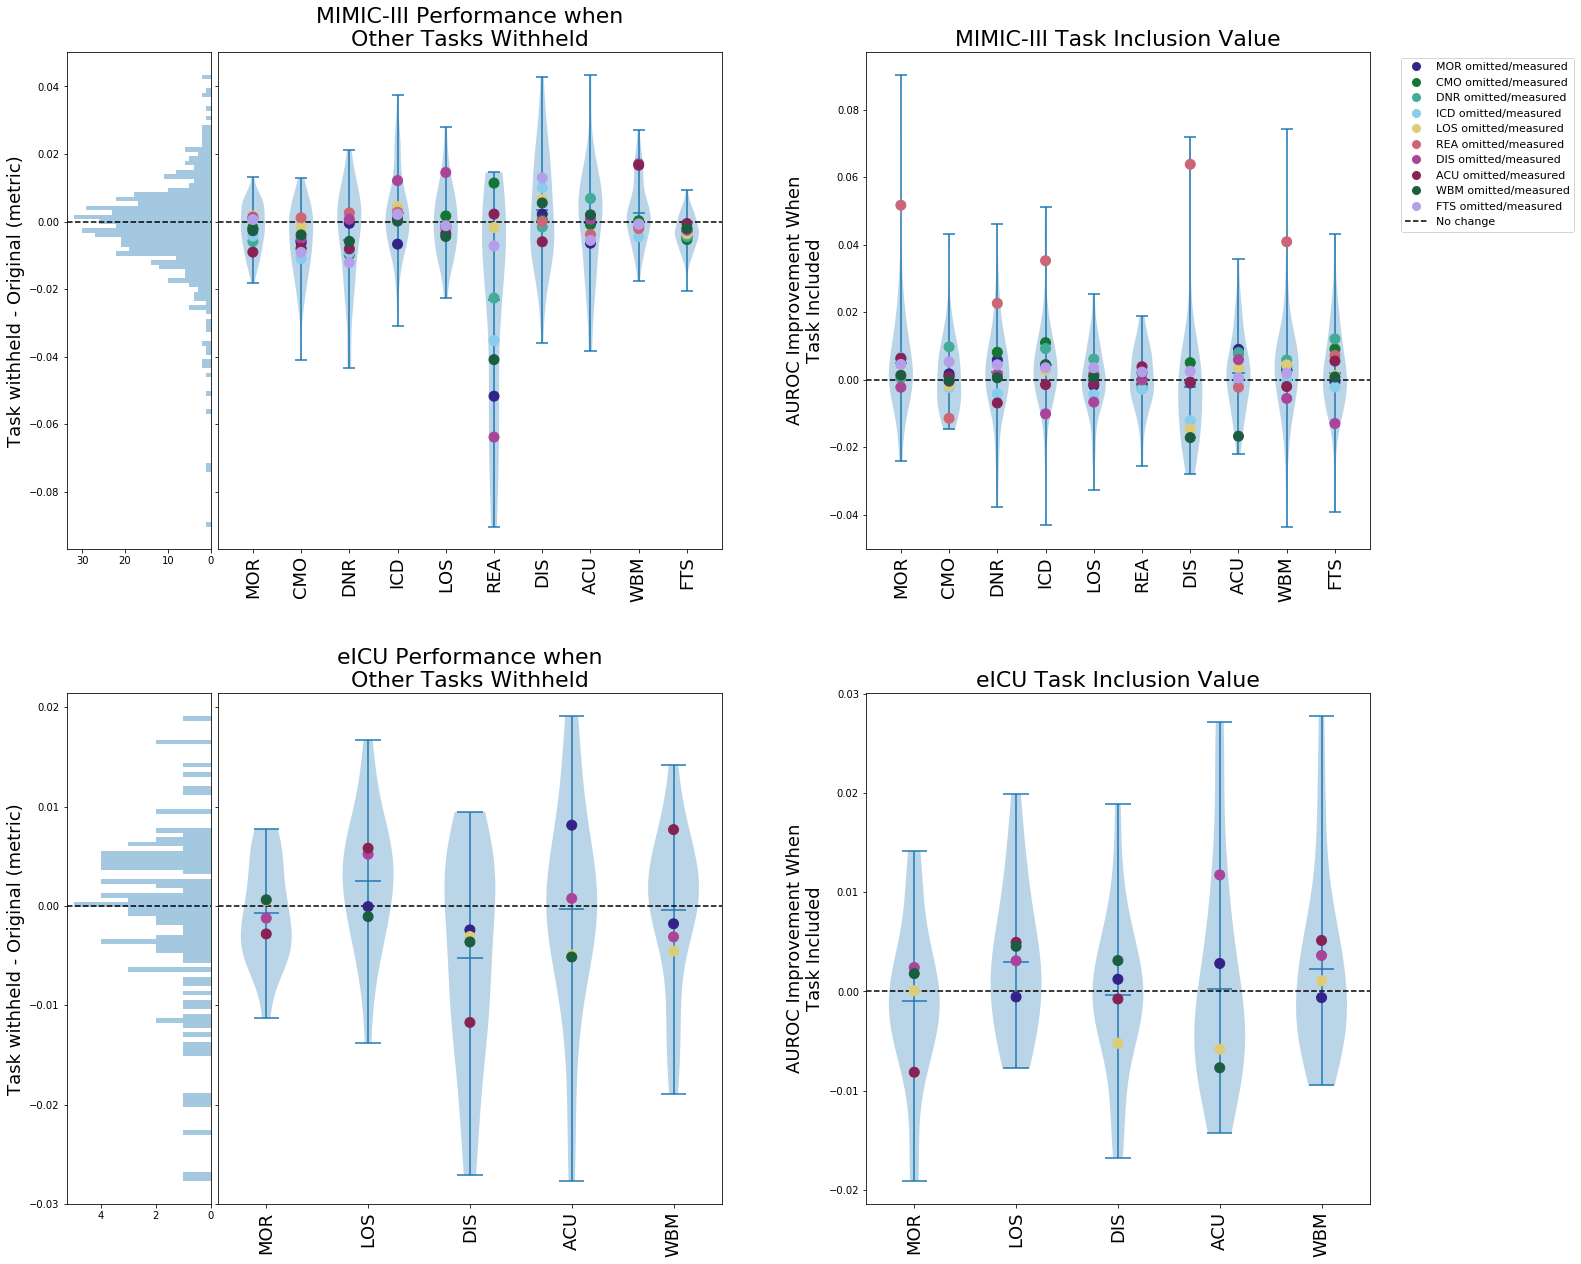

In [28]:
MT_PT, full_MT, deltas = get_negative_transfer_studies_hist(full, hyperparameter_search_results, sp='test')

In [29]:
ST_results = {
    'MIMIC-III': reorged_full['MIMIC-III']['ST']['gru'][('test', 'AUROC')][1]['FTF_on_target'],
    'eICU': reorged_full['eICU']['ST']['gru'][('test', 'AUROC')][1]['FTF_on_target'],
}

ST_vs_MT = {
    'MIMIC-III': (pd.DataFrame(full_MT['MIMIC-III']) - ST_results['MIMIC-III']).agg(('mean', 'std'), axis=1),
    'eICU': (pd.DataFrame(full_MT['eICU']) - ST_results['eICU']).agg(('mean', 'std'), axis=1),
}

for dataset, df in ST_vs_MT.items():
    df.columns = pd.MultiIndex.from_tuples([(dataset, c) for c in df.columns], names=['Dataset', 'Agg'])
    
joint = ST_vs_MT['MIMIC-III'].join(ST_vs_MT['eICU'])

def row_to_str(r): 
    if np.isnan(r['mean']): return ''
    else: return f"${r['mean'].round(2)} \pm {r['std'].round(2)}$"
    
joint_str = pd.DataFrame({
    d: joint[d].apply(row_to_str, axis=1) for d in ('MIMIC-III', 'eICU')
})
display(joint_str)
print(joint_str.to_latex(escape=False))

,MIMIC-III,eICU
ACU,$-0.02 \pm 0.02$,$0.01 \pm 0.02$
CMO,$0.02 \pm 0.02$,
DIS,$0.0 \pm 0.01$,$0.0 \pm 0.01$
DNR,$0.01 \pm 0.03$,
FTS,$0.0 \pm 0.01$,
ICD,$-0.07 \pm 0.04$,
LOS,$-0.02 \pm 0.03$,$-0.0 \pm 0.02$
MOR,$-0.0 \pm 0.01$,$0.01 \pm 0.01$
REA,$0.01 \pm 0.04$,
WBM,$-0.08 \pm 0.03$,$-0.01 \pm 0.02$


\begin{tabular}{lll}
\toprule
{} &         MIMIC-III &              eICU \\
\midrule
ACU &  $-0.02 \pm 0.02$ &   $0.01 \pm 0.02$ \\
CMO &   $0.02 \pm 0.02$ &                   \\
DIS &    $0.0 \pm 0.01$ &    $0.0 \pm 0.01$ \\
DNR &   $0.01 \pm 0.03$ &                   \\
FTS &    $0.0 \pm 0.01$ &                   \\
ICD &  $-0.07 \pm 0.04$ &                   \\
LOS &  $-0.02 \pm 0.03$ &   $-0.0 \pm 0.02$ \\
MOR &   $-0.0 \pm 0.01$ &   $0.01 \pm 0.01$ \\
REA &   $0.01 \pm 0.04$ &                   \\
WBM &  $-0.08 \pm 0.03$ &  $-0.01 \pm 0.02$ \\
\bottomrule
\end{tabular}

